In [1]:
import os
import csv
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from astropy.io import fits as pf
from lmfit import Model, Parameters, models


In [2]:

def readfits(idlist, path, skysub=False):
    ''' Extract wavelength, flux, hjd from .fits '''

    for star in idlist:
        datapath = path+'BBC_'+str(star).zfill(3)+'/'
        dest = path+'BBC_'+str(star).zfill(3)+'/'
        fitslist = sorted(glob(datapath+'BBC_'+'*.fits'))

        names_fits = [w.replace(datapath+'','') for w in fitslist]
        names_dat = [w.replace('.fits','.dat') for w in names_fits]
        names_cfits = [w.replace('BBC','cBBC') for w in names_fits]
        df_names_fits = pd.DataFrame(names_fits)
        df_names_dat = pd.DataFrame(names_dat)
        df_names_cfits = pd.DataFrame(names_cfits)

        if not os.path.exists(dest+'data'):
            os.makedirs(dest+'data')
        df_names_fits.to_csv(dest+'data/fits_list.dat', index=False, header=False,sep='\t')
        df_names_dat.to_csv(dest+'data/dat_list.dat', index=False, header=False,sep='\t')
        df_names_cfits.to_csv(dest+'data/cfits_list.dat', index=False, header=False,sep='\t')

        wave, flux, err, hjd = [], [], [], []

        for i in range(len(fitslist)):
            with pf.open(fitslist[i]) as hdu:
                # if i == 0:
                #     print(hdu.info())
                    # print(repr(hdu[0].header[10:50]))
                    # print(repr(hdu[2].data))
                # sys.exit()
                n=0
                m=1

                lengthx =  hdu[0].header['NAXIS1']
                refx    =  hdu[0].header['CRPIX1']
                stepx   =  hdu[0].header['CDELT1']
                startx  =  hdu[0].header['CRVAL1']
                flux.append(hdu[n].data)
                wave.append((np.arange(lengthx) - (refx - 1))*stepx + startx )
                err.append(hdu[m].data)
                hjd.append(hdu[0].header['HJD'])

                dd = {'Wavelength':wave[i],'Flux':flux[i], 'Error':err[i]}
                df = pd.DataFrame(dd, columns=['Wavelength','Flux', 'Error'])
                df.to_csv(dest+'data/'+ names_dat[i], index=False, header=False,sep='\t')

        epochs = [w.replace('.fits','') for w in names_fits]

        df_hjd = pd.DataFrame(hjd, columns=['HJD'])
        df_hjd.insert(0, 'Epochs', epochs)
        df_hjd.to_csv(dest+'JDs.dat', index=False, header=False,sep='\t')
        print('.fits converted to .dat for star ', star)
    return wave, flux, err, hjd

def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return -amp*np.exp(-(x-cen)**2 /(2*(wid/2.355)**2))

def lorentzian(x, amp, cen, wid):
    "1-d lorentzian: lorentzian(x, amp, cen, wid)"
    return -amp*(wid**2/( 4*(x-cen)**2 + wid**2 ))

def nebu(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return amp*np.exp(-(x-cen)**2 /(2*(wid/2.355)**2))

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def gaussfit(idlist, path, plots=True, balmer=True, neblines=[[4102, 4340]], doubem=[], SB2=False, use_init_pars=False):

    # doubem = doubem[0]
    Hlines = [4102, 4340]
    best_lines, best_lines_index = [], []
    for star, nebline in zip(idlist, neblines):
        print( '\n********************************************************************************' )
        print( '******************       Gaussian fitting: star BBC '+str(star)+'       ******************' )
        print( '********************************************************************************\n' )

        print('*** SB2: ', SB2, ' ***\n')

        path = path+'BBC_'+str(star).zfill(3)+'/'
        datapath = 'spectra/BBC_'+str(star).zfill(3)+'/'

        filelist = sorted(glob(datapath+'data/BBC*.dat'))

        df_OB = pd.read_csv('spectra/BBC_'+str(star).zfill(3)+'/JDs.dat', sep='\t', usecols=[0], header=None)

        wave, flux, err, names = [], [], [], []
        for j in range(len(filelist)):
            names.append(filelist[j].replace('.dat','').replace(path+'data/',''))
            df = pd.read_csv(filelist[j],sep='\t',header=None)
            wave.append(np.array(df[0]))
            flux.append(np.array(df[1]))
            err.append(np.array(df[2]))



        if balmer == False:
            lines    = [4026, 4144, 4388, 4471, 4553]
            cen_ini  = [4030, 4147, 4392, 4475, 4557]
            cen_ineb = [4030, 4148, 4392, 4475, 4557]
            lim_wav  = [[4017, 4042], [4135, 4160], [4380, 4405], [4462, 4487], [4547, 4572]]
            wid_ini  = [4, 4, 4, 4, 2.5]
            w = [2.5, 2.5, 2.1, 2.1, 2.1]

        elif balmer == True:
            lines    = [4026, 4102, 4144, 4340, 4388, 4471, 4553]
            cen_ini  = [4030, 4105, 4147, 4345, 4392, 4475, 4556.5]
            cen_ineb = [4030, 4105, 4148, 4344, 4392, 4475, 4556.5]
            lim_wav  = [[4017, 4043], [4079+10, 4130-10], [4135, 4160], [4325+5, 4365-5], [4380, 4405], [4462, 4487], [4547, 4572]]
            wid_ini  = [4, 7, 3, 7, 4, 4, 2.5]
            # wid_ini  = [3, 4, 3, 4, 3, 3, 2.5]
            w = [2.8, 2.5, 2.8, 1.5, 2.5, 2.5, 2.1]

        print('these are the lines: ', lines)

        median   = []
        ww, ff             = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        cen1, cen1_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        amp1, amp1_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        wid1, wid1_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        cen2, cen2_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        amp2, amp2_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        wid2, wid2_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        dely, sdev         = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        results, comps     = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        delta_cen, chisqr  = [[] for i in range(len(lines))], [[] for i in range(len(lines))]

        for i in range(len(lines)):
            for j in range(len(wave)):
                ww[i].append(np.logical_and(wave[j] > lim_wav[i][0], wave[j] < lim_wav[i][1]))
                sdev[i].append(np.std(flux[j][ww[i][j]]))
           # print('mean of std devs for all epochs of line ',lines[i],' = ',np.mean(sdev[i]))
           # print('median of std devs for all epochs of line ',lines[i],' = ',np.median(sdev[i]))
           # print('mode of std devs for all epochs of line ',lines[i],' = ',stats.mode(sdev[i]))
            median.append(np.median(sdev[i]))
        # fit1
        print( '\n')
        print( '*** Performing 1st fit ***')
        print( '--------------------------')

        # out_pars = open(path+'init_pars.dat', 'w')
        # if os.path.isfile('init_pars.dat')==True:
        #     df_init_pars = pd.read_csv('init_pars.dat', sep=',')
        # out_pars.write('line,'+'param,'+'value,'+'min,'+'max'+'\n')

        for i in range(len(lines)):
            out_file = []
            if SB2==True:
                out_file = open(path+str(lines[i])+'_stats_0.dat', 'w')
            else:
                out_file = open(path+str(lines[i])+'_stats.dat', 'w')

            print('fitting line ', lines[i])
            
            for j in range(len(wave)):
                if lines[i] in Hlines:
                    ff[i].append(flux[j][ww[i][j]] < np.mean(flux[j][ww[i][j]])+10*median[i])
                else:
                    ff[i].append(flux[j][ww[i][j]] < np.mean(flux[j][ww[i][j]])+30*median[i])
               # print('line', lines[i], ' epoch', j, ' len(ff[i][j]):', len(ff[i][j]))
                x_wave = wave[j][ww[i][j]][ff[i][j]]
                y_flux = flux[j][ww[i][j]][ff[i][j]]
                x_ymax = x_wave[y_flux.argmax()]
                x_ymin = x_wave[y_flux.argmin()]
                
                pars = Parameters()
                gauss1 = Model(gaussian, prefix='g1_')
                gauss2 = Model(gaussian, prefix='g2_')
                loren1 = Model(lorentzian, prefix='l1_')
                loren2 = Model(lorentzian, prefix='l2_')
                nebem = Model(nebu, prefix='neb_')
                nebem2 = Model(nebu, prefix='neb2_')
                cont = models.LinearModel(prefix='continuum_')
                pars.update(cont.make_params())
                pars['continuum_slope'].set(0, vary=False)
                pars['continuum_intercept'].set(1, min=0.9)
                if lines[i] in Hlines:
                    pars.update(loren1.make_params())
                    pars['l1_amp'].set(1.2-y_flux.min(), min=0.01, max=2. )
                    # pars['l1_wid'].set(wid_ini[i]+3, min=3, max=11)
                    pars['l1_wid'].set(wid_ini[i], min=1, max=11)
                    pars['l1_cen'].set(cen_ini[i], min=cen_ini[i]-4, max=cen_ini[i]+4)
                    mod = loren1 + cont
                    if lines[i] in nebline:
                        pars.update(nebem.make_params())
                        pars['neb_amp'].set(y_flux.max()-y_flux.min(), min=0.01)#, max=65)
                        pars['neb_wid'].set(1)#, min=0.1, max=4)
                        pars['neb_cen'].set(cen_ineb[i]+0.5)#, min=cen_ineb[i]-4, max=cen_ineb[i]+4)
                        mod = loren1 + nebem + cont
                        if lines[i] in doubem:
                            pars.update(nebem2.make_params())
                            pars['neb2_amp'].set(y_flux.max()-y_flux.min(), min=0.01)#, max=65)
                            pars['neb2_wid'].set(1)#, min=0.1, max=4)
                            pars['neb2_cen'].set(cen_ineb[i]-0.5)#, min=cen_ineb[i]-4, max=cen_ineb[i]+4)
                            mod = loren1 + nebem + nebem2 + cont
                if not lines[i] in Hlines:
                    if SB2==False:
                        pars.update(gauss1.make_params())
                        pars.add('g1_amp', value=1-y_flux.min(), min=0.05, max=0.4)
                        pars.add('g1_cen', value=cen_ini[i], vary=True)

                        if lines[i]==4553:
                            pars.add('g1_wid', value=wid_ini[i]-1.5, min=0.3, max=2.)
                            pars.add('g1_cen', value=cen_ini[i], vary=True)
                        else:
                            pars.add('g1_wid', value=wid_ini[i], min=0.5, max=7.)
                        mod = gauss1 + cont
                        if lines[i] in nebline:
                            pars.update(nebem.make_params())
                            pars['neb_cen'].set(cen_ineb[i], min=cen_ineb[i]-1.5, max=cen_ineb[i]+1.5)
                            pars['neb_wid'].set(1., min=0.05, max=1.8)
                            if y_flux.max() < 1.2:
                                pars['neb_amp'].set((1-y_flux.min())/2, min=0.001, max=0.5)
                            else:
                                pars['neb_amp'].set((y_flux.max()-y_flux.min())/1.1, min=0.05)#, max=65)
                            mod = gauss1 + nebem + cont
                            if lines[i] in doubem:
                                pars.update(nebem2.make_params())
                                pars['neb2_amp'].set(1-y_flux.min(), min=0.01, max=25)
                                pars['neb2_wid'].set(0.5, min=0.05, max=5)
                                pars['neb2_cen'].set(cen_ineb[i]-1, min=cen_ineb[i]-4-1, max=cen_ineb[i]+4-1)
                                mod = gauss1 + nebem + nebem2 + cont
                    if SB2==True:
                        if use_init_pars==True:
                            pars.update(gauss1.make_params())
                            pars.add('g1_amp', value=1-y_flux.min(), min=0.05, max=0.4)
                            # pars.add('g1_cen', value=cen_ini[i]-1., min=cen_ini[i]-7, max=cen_ini[i]+7)
                            pars.add('g1_cen', value=cen_ini[i]-2., vary=True)

                            if lines[i]==4553:
                                pars.add('g1_wid', value=wid_ini[i]-1.5, min=0.3, max=2.)
                                pars.add('g1_cen', value=cen_ini[i], vary=True)
                            else:
                                pars.add('g1_wid', value=wid_ini[i]-0., min=0.5, max=4.)

                            pars.update(gauss2.make_params())
                            # pars.add('g2_cen', value=cen_ini[i]+2, min=cen_ini[i]-7, max=cen_ini[i]+7)
                            pars.add('g2_cen', value=cen_ini[i]+2., vary=True)
                            pars.add('g2_amp', 0.5*(1-y_flux.min()), min=0.05, max=0.3)
                            # pars.add('g2_wid', value=wid_ini[i], min=2, max=6)
                            if lines[i]==4553:
                                pars.add('g2_wid', value=wid_ini[i]-1.5, min=0.3, max=2.)
                                pars.add('g2_cen', value=cen_ini[i]+1.5, vary=True)
                            else:
                                pars.add('g2_wid', value=wid_ini[i]-1., min=0.5, max=4.)
                               # pars.add('g2_cen', value=cen_ini[i]+2., min=cen_ini[i]-5, max=cen_ini[i]+5)
                            mod = gauss1 + gauss2 + cont
                        else:
                            pars.update(gauss1.make_params())
                            pars.add('g1_amp', value=1-y_flux.min(), min=0.05, max=0.4)
                            # pars.add('g1_cen', value=cen_ini[i]-1., min=cen_ini[i]-7, max=cen_ini[i]+7)
                            pars.add('g1_cen', value=cen_ini[i]-2.0, vary=True)
                            if lines[i]==4553:
                                pars.add('g1_wid', value=wid_ini[i]-1.5, min=0.3, max=2.)
                                pars.add('g1_cen', value=cen_ini[i]-0.8, vary=True)
                            else:
                                pars.add('g1_wid', value=wid_ini[i]-1.5, min=0.5, max=3.5)

                            pars.update(gauss2.make_params())
                            pars.add('g2_amp', 0.5*(1-y_flux.min()), min=0.05, max=0.3)
                            # pars.add('g2_cen', value=cen_ini[i]+2, min=cen_ini[i]-7, max=cen_ini[i]+7)
                            pars.add('g2_cen', value=cen_ini[i]+2.0, vary=True)
                            # pars.add('g2_wid', value=wid_ini[i], min=2, max=6)
                            if lines[i]==4553:
                                pars.add('g2_wid', value=wid_ini[i]-1.5, min=0.3, max=2.)
                                pars.add('g2_cen', value=cen_ini[i]+0.8, vary=True)
                            else:
                                pars.add('g2_wid', value=wid_ini[i]-1.5, min=0.5, max=3.5)
                               # pars.add('g2_cen', value=cen_ini[i]+2., min=cen_ini[i]-5, max=cen_ini[i]+5)
                            mod = gauss1 + gauss2 + cont
                        if lines[i] in nebline:
                            pars.update(nebem.make_params())
                            pars['neb_cen'].set(cen_ineb[i], min=cen_ineb[i]-1, max=cen_ineb[i]+1)
                            pars['neb_wid'].set(1., min=0.05, max=1.6)
                            if y_flux.max() < 1.2:
                                pars['neb_amp'].set((1-y_flux.min())/2, min=0.001, max=0.5)
                            else:
                                pars['neb_amp'].set((y_flux.max()-y_flux.min())/1.1, min=0.05)#, max=65)
                            mod = gauss1 + gauss2 + nebem + cont
                            if lines[i] in doubem:
                                pars.update(nebem2.make_params())
                                pars['neb2_amp'].set(1-y_flux.min(), min=0.01, max=25)
                                pars['neb2_wid'].set(0.5, min=0.05, max=5)
                                pars['neb2_cen'].set(cen_ineb[i]-1.5, min=cen_ineb[i]-4-1, max=cen_ineb[i]+4-1)
                                mod = gauss1 + gauss2 + nebem + nebem2 + cont

                results[i].append(mod.fit(y_flux, pars, x=x_wave, weights=1/err[j][ww[i][j]][ff[i][j]]))
                chisqr[i].append(results[i][j].chisqr)
                if lines[i] in nebline or SB2==True:
                    comps[i].append(results[i][j].eval_components(results[i][j].params, x=x_wave))
                else:
                    comps[i].append(0)
                # for pname, par in pars.items():
                #     print('line', lines[i], ' epoch', j+1, pname, par)

                out_file.write(names[j]+'\n')
                out_file.write(results[i][j].fit_report()+'\n')

                if not 'g2_cen' in results[i][j].params and not 'l1_cen' in results[i][j].params:
                    cen1[i].append(results[i][j].params['g1_cen'].value)
                    cen1_er[i].append(results[i][j].params['g1_cen'].stderr)
                    amp1[i].append(results[i][j].params['g1_amp'].value)
                    amp1_er[i].append(results[i][j].params['g1_amp'].stderr)
                    wid1[i].append(results[i][j].params['g1_wid'].value)
                    wid1_er[i].append(results[i][j].params['g1_wid'].stderr)
                if 'g2_cen' in results[i][j].params:
                    if results[i][j].params['g1_amp'].value > results[i][j].params['g2_amp'].value:
                        cen1[i].append(results[i][j].params['g1_cen'].value)
                        cen1_er[i].append(results[i][j].params['g1_cen'].stderr)
                        amp1[i].append(results[i][j].params['g1_amp'].value)
                        amp1_er[i].append(results[i][j].params['g1_amp'].stderr)
                        wid1[i].append(results[i][j].params['g1_wid'].value)
                        wid1_er[i].append(results[i][j].params['g1_wid'].stderr)
                        cen2[i].append(results[i][j].params['g2_cen'].value)
                        cen2_er[i].append(results[i][j].params['g2_cen'].stderr)
                        amp2[i].append(results[i][j].params['g2_amp'].value)
                        amp2_er[i].append(results[i][j].params['g2_amp'].stderr)
                        wid2[i].append(results[i][j].params['g2_wid'].value)
                        wid2_er[i].append(results[i][j].params['g2_wid'].stderr)
                    else:
                        cen1[i].append(results[i][j].params['g2_cen'].value)
                        cen1_er[i].append(results[i][j].params['g2_cen'].stderr)
                        amp1[i].append(results[i][j].params['g2_amp'].value)
                        amp1_er[i].append(results[i][j].params['g2_amp'].stderr)
                        wid1[i].append(results[i][j].params['g2_wid'].value)
                        wid1_er[i].append(results[i][j].params['g2_wid'].stderr)
                        cen2[i].append(results[i][j].params['g1_cen'].value)
                        cen2_er[i].append(results[i][j].params['g1_cen'].stderr)
                        amp2[i].append(results[i][j].params['g1_amp'].value)
                        amp2_er[i].append(results[i][j].params['g1_amp'].stderr)
                        wid2[i].append(results[i][j].params['g1_wid'].value)
                        wid2_er[i].append(results[i][j].params['g1_wid'].stderr)
                if 'l1_cen' in results[i][j].params:
                    cen1[i].append(results[i][j].params['l1_cen'].value)
                    cen1_er[i].append(results[i][j].params['l1_cen'].stderr)
                    amp1[i].append(results[i][j].params['l1_amp'].value)
                    amp1_er[i].append(results[i][j].params['l1_amp'].stderr)
                    wid1[i].append(results[i][j].params['l1_wid'].value)
                    wid1_er[i].append(results[i][j].params['l1_wid'].stderr)
               # if results[i][j].params['g1_cen'].stderr==None or results[i][j].params['g1_amp'].stderr==None:
                if cen1_er[i][j]==None or amp1_er[i][j]==None:
                    print('errors computation failed for line ', lines[i], 'epoch ', j+1)
               # if results[i][j].params['g1_cen'].stderr != 0 and results[i][j].params['g1_cen'].stderr != None:
                if cen1_er[i][j] != 0 and cen1_er[i][j] != None:
                    dely[i].append(results[i][j].eval_uncertainty(sigma=3))
                else:
                    dely[i].append(0)
            out_file.close()
        #     for pname, par in pars.items():
        #         out_pars.write(str(lines[i])+','+str(par).replace('<Parameter', '').replace(']>', '')\
        #             .replace('bounds=[', '').replace(':', ', ').replace('value=', '').replace('(fixed)', '').replace(' ', '')+'\n')
        # out_pars.close()
        print(' ...fit done')
        # sys.exit()
        ########################################################################

        '''
        Plotting 1st fits of the lines
        '''
        if plots==True:
            print('\nPloting line fits...')
            for i in range(len(lines)):
                nrows=len(wave)//4

                # elif len(wave)%4 != 0:
                fig, axes = plt.subplots(nrows=nrows+1, ncols=4, figsize=(12,13), sharey=True, sharex=False)
                fig.subplots_adjust(left=0.07, right=0.98, top=0.97, bottom=0.05, wspace=0.,hspace=0.)
                axes = trim_axs(axes, len(wave))
                # ax1 = fig.add_subplot(nrows,4,1)
                for ax, j in zip(axes, range(len(wave))):
                    #j = a*4+b
                    # plt.subplot(nrows+1, 4, j+1, sharex=ax1, sharey=ax1)
                    ax.plot(wave[j][ww[i][j]][ff[i][j]], flux[j][ww[i][j]][ff[i][j]], 'k-', lw=3, ms=4, zorder=1, label=str(names[j].replace('./','').replace('_',' ')))
                    ax.plot(wave[j][ww[i][j]][ff[i][j]], results[i][j].init_fit, '--', c='grey', zorder=5)
                    ax.plot(wave[j][ww[i][j]][ff[i][j]], results[i][j].best_fit, 'r-', lw=2, zorder=4)

                    if comps[i][j] != 0:
                        if lines[i] in Hlines:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['l1_'], '--', zorder=3, c='limegreen', lw=2)#, label='spectral line')
                        if SB2==True and not lines[i] in Hlines:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g1_'], '--', zorder=3, c='blue', lw=2)#, label='spectral line')
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g2_'], '--', zorder=3, c='blue', lw=2)#, label='spectral line')
                        if lines[i] in nebline:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['neb_'], '--', zorder=3, c='orange', lw=2)#, label='nebular emision')
                        if lines[i] in nebline and not lines[i] in Hlines and SB2==False:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g1_'], '--', zorder=3, c='limegreen', lw=2)#, label='spectral line')
                            #plt.hlines(np.mean(y_flux)+median[i], lim_wav[i][0], lim_wav[i][1], color='magenta', linestyles='--',linewidth=1.)

                    if dely[i] != 0:
                        ax.fill_between(wave[j][ww[i][j]][ff[i][j]], results[i][j].best_fit-dely[i][j], results[i][j].best_fit+dely[i][j], zorder=2, color="#ABABAB", alpha=0.5)
                    if j < 25:
                        # plt.axis('off')
                        ax.tick_params(axis='both', labelbottom=False)

                    ax.legend(loc='upper center',fontsize=16, handlelength=0, handletextpad=0.4, borderaxespad=0., frameon=False)
                    # plt.tick_params(which='both', width=0.5, labelsize=11)
                    #ax1.set(ylim=(min(y_flux)-0.2, max(y_flux)+0.2))
                    if max(flux[j][ww[i][j]][ff[i][j]])>1.3 or min(flux[j][ww[i][j]][ff[i][j]])<0.4 or \
                        max(results[i][j].best_fit-dely[i][j])>1.3 or min(results[i][j].best_fit-dely[i][j])<0.4:
                        if lines[i] in Hlines:
                            ax.set(ylim=(0.5, 1.3))
                        elif lines[i] not in Hlines:
                            ax.set(ylim=(0.6, 1.2))
                    if comps[i][j] != 0:
                        if lines[i] in nebline:
                            if max(flux[j][ww[i][j]][ff[i][j]])>1.3 or min(flux[j][ww[i][j]][ff[i][j]])<0.4 or \
                                max(results[i][j].best_fit-dely[i][j])>1.3 or min(results[i][j].best_fit-dely[i][j])<0.4 \
                                or max(1+comps[i][j]['neb_'])>1.3:
                                if lines[i] in Hlines:
                                    ax.set(ylim=(0.5, 1.3))
                                elif lines[i] not in Hlines:
                                    ax.set(ylim=(0.6, 1.2))
                   #     else:
                   #         if max(flux[j][ww[i][j]][ff[i][j]])>1.3 or min(flux[j][ww[i][j]][ff[i][j]])<0.4 or \
                   #             max(results[i][j].best_fit-dely[i][j])>1.3 or min(results[i][j].best_fit-dely[i][j])<0.4:
                   #             if lines[i] in Hlines:
                   #                 ax1.set(ylim=(0.5, 1.3))
                   #             elif lines[i] not in Hlines:
                   #                 ax1.set(ylim=(0.6, 1.2))
                   # x=0.05
                    # y0=-0.1 # for BBC 847
                    y0=0.05
                    y1=0.02
                    if lines[i]==4026:
                        ax.set(ylim=(0.7-y0, 1.11+y1))
                    # if i==1:
                    #     ax1.set(ylim=(0.65, 1.5))
                    if lines[i]==4144:
                        ax.set(ylim=(0.8-y0, 1.11+y1))
                    if lines[i]==4102:
                        ax.set(ylim=(0.5, 1.4))
                    if lines[i]==4340:
                        ax.set(ylim=(0.5, 1.9))
                    if lines[i]==4388:
                        ax.set(ylim=(0.75-y0, 1.11+y1))
                        ax.set_xticks([4385,4395,4405])
                    if lines[i]==4471:
                        ax.set(ylim=(0.75-y0, 1.11+y1))
                        ax.set_xticks([4465,4475,4485])
                    if lines[i]==4553:
                        ax.set(ylim=(0.8+y0, 1.11+y1))


                # for n in range(1, (nrows+1)*4-len(wave)+1 ):
                #     ax[-1, -n].axis('off')

                fig.text(0.52, 0.01, 'Wavelength', ha='center',fontsize=24)
                fig.text(0.01, 0.5, 'Flux', va='center', rotation='vertical',fontsize=24)
                if SB2==True:
                    plt.savefig(path+str(star).zfill(3)+str(lines[i])+'_fits_0_.png')
                else:
                    plt.savefig(path+str(star).zfill(3)+str(lines[i])+'_fits.png')
                #plt.show()
                plt.close()
                print(lines[i])
            print(' ...plots done')

        # sys.exit()

        #########################################################################

        if SB2==True:
            print( '\n')
            print( '*** Performing 2nd fit ***')
            print( '--------------------------')
            print( '\n')
            #print(len(cen1[1]), len(cen2[1]))
            for i in range(len(lines)):
                for j in range(len(wave)):
                    if not lines[i] in Hlines:
                        delta_cen[i].append(abs(cen2[i][j]-cen1[i][j]))
                    else:
                        delta_cen[i].append(np.nan)
                    if amp1_er[i][j]!=None and amp2_er[i][j]!=None:
                    #     print('delta_cen = ', f'{abs(cen2[i][j]-cen1[i][j]):.2f}', 'line ', lines[i], 'epoch ', j+1, 'amp1_er', f'{amp1_er[i][j]:.2f}', 'amp2_er', f'{amp2_er[i][j]:.2f}', 'wid1_er', f'{wid1_er[i][j]:.2f}', 'wid2_er', f'{wid2_er[i][j]:.2f}')
                    # else:
                    #     print('delta_cen = ', f'{abs(cen2[i][j]-cen1[i][j]):.2f}', 'line ', lines[i], 'epoch ', j+1)
                        print(lines[i], ' ep', f'{j+1:2}', ' amp1 =', f'{amp1[i][j]:.2f}', ' amp2 =', f'{amp2[i][j]:.2f}', \
                                ' amp1_er =', f'{100*amp1_er[i][j]/amp1[i][j]:4.1f}', ' amp2_er =', f'{100*amp2_er[i][j]/amp2[i][j]:4.1f}', \
                                ' wid1 =', f'{wid1[i][j]:.3f}', ' wid2 =', f'{wid2[i][j]:.3f}', \
                                ' wid1_er =', f'{100*wid1_er[i][j]/wid1[i][j]:4.1f}', ' wid2_er =', f'{100*wid2_er[i][j]/wid2[i][j]:4.1f}', \
                                ' delta_cen =', f'{delta_cen[i][j]:.3f}', 'amp2/amp1 =', f'{amp2[i][j]/amp1[i][j]:.2f}')
                print('\n')
                # print('delta_cen line', lines[i], np.mean( delta_cen[i]))

            mean_amp1, mean_amp2, mean_cen1, mean_cen2, mean_wid1, mean_wid2 = [], [], [], [], [], []
            best_amp1, best_amp2, best_cen1, best_cen2, best_wid1, best_wid2 = [[] for i in range(len(lines))], [[] for i in range(len(lines))], [[] for i in range(len(lines))], [[] for i in range(len(lines))], [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            print('Epochs used for 2nd fit:')
            print('------------------------')
            # sep_cte = [-1., -0.5, -0.2, -1., -1.]
            sep_cte = [-1.7, -0.8, -0.6, -1.5, 0.0]
            amp_per = [0.35, 0.35, 0.35, 0.35, 0.35]
            wid_per = [0.35, 0.35, 0.35, 0.35, 0.35]
            min_wid = [1.5, 1.2, 1.2, 1.5, 0.5]
            # sep_cte = [0.2, -0.8, 0.2, -0.8, -1.]
            # amp_per = [0.30, 0.30, 0.30, 0.30, 0.30]
            # wid_per = [0.35, 0.30, 0.35, 0.35, 0.35]
            seplus =0.
            out_sep = open(path+'sep_cte.dat', 'w')
            out_sep.write('line'+' '+'sep_cte'+' '+'amp_per'+' '+'wid_per'+' '+'\n')
            for line, sep, amp, wid in zip(lines, sep_cte, amp_per, wid_per):
                out_sep.write(str(line)+' '+str(sep)+' '+str(amp)+' '+str(wid)+'\n')
            out_sep.close()
            for i in range(len(lines)):
                if not lines[i] in Hlines:
                    print('delta_cen[i][j] >', f'{np.mean( delta_cen[i])+sep_cte[i]:.3f}')
                    for j in range(len(wave)):
                        if delta_cen[i][j] > np.mean( delta_cen[i])+sep_cte[i] \
                        and amp1_er[i][j]!=None and amp2_er[i][j]!=None \
                        and amp1_er[i][j]<(amp_per[i]+seplus)*amp1[i][j] and amp2_er[i][j]<(amp_per[i]+seplus)*amp2[i][j]\
                        and wid1[i][j]>min_wid[i] and wid2[i][j]>min_wid[i] \
                        and wid1_er[i][j]!=None and wid2_er[i][j]!=None \
                        and wid1_er[i][j]<(wid_per[i]+seplus)*wid1[i][j] and wid2_er[i][j]<(wid_per[i]+seplus)*wid2[i][j]:
                            if 100*amp1_er[i][j]/amp1[i][j]>3. and 100*wid1_er[i][j]/wid1[i][j]>3. \
                            and 100*amp2_er[i][j]/amp2[i][j]>3. and 100*wid2_er[i][j]/wid2[i][j]>3. \
                            and amp2[i][j]/amp1[i][j]>0.3 and j+1 not in [10, 12, 13]:
                           # if amp1_er[i][j]!=None and amp2_er[i][j]!=None:
                           #     print('line', lines[i], ' epoch', j+1, ' amp1 =', f'{amp1[i][j]:.3f}', ' amp2 =', f'{amp2[i][j]:.3f}', ' amp1>amp2:', round(amp1[i][j], 3)>round(amp2[i][j], 3), \
                           #         ' amp1_er =', f'{amp1_er[i][j]:.3f}', ' amp2_er =', f'{amp2_er[i][j]:.3f}')
                           #     print('line', lines[i], ' epoch', j+1, ' amp1 =', f'{amp1[i][j]:.3f}', ' cen1 =', f'{cen1[i][j]:.3f}', ' amp2 =', f'{amp2[i][j]:.3f}', ' cen2 =', f'{cen2[i][j]:.3f}', ' amp1>amp2:', round(amp1[i][j], 3)>round(amp2[i][j], 3) )
                                print(lines[i], ' ep', f'{j+1:2}', ' amp1 =', f'{amp1[i][j]:.2f}', ' amp2 =', f'{amp2[i][j]:.2f}', \
                                        ' amp1_er =', f'{100*amp1_er[i][j]/amp1[i][j]:4.1f}', ' amp2_er =', f'{100*amp2_er[i][j]/amp2[i][j]:4.1f}', \
                                        ' wid1 =', f'{wid1[i][j]:.3f}', ' wid2 =', f'{wid2[i][j]:.3f}', \
                                        ' wid1_er =', f'{100*wid1_er[i][j]/wid1[i][j]:4.1f}', ' wid2_er =', f'{100*wid2_er[i][j]/wid2[i][j]:4.1f}', \
                                        ' delta_cen =', f'{delta_cen[i][j]:.3f}', 'amp2/amp1 =', f'{amp2[i][j]/amp1[i][j]:.2f}')
                                # print('line', lines[i], ' epoch', f'{j+1:2}', f'{amp1_er[i][j]:.3f}', f'{amp_per[i]*amp1[i][j]:.3f}')
                                # print('line', lines[i], ' epoch', f'{j+1:2}', 100*amp2_er[i][j]/amp2[i][j])
                                best_amp1[i].append([amp1[i][j], amp1_er[i][j]])
                                best_cen1[i].append([cen1[i][j], cen1_er[i][j]])
                                best_wid1[i].append([wid1[i][j], wid1_er[i][j]])
                                best_amp2[i].append([amp2[i][j], amp2_er[i][j]])
                                best_cen2[i].append([cen2[i][j], cen2_er[i][j]])
                                best_wid2[i].append([wid2[i][j], wid2_er[i][j]])

            # sys.exit()
            amp1_w = [[1/(x[1]**2) for x in sublist] for sublist in best_amp1]
            cen1_w = [[1/(x[1]**2) for x in sublist] for sublist in best_cen1]
            wid1_w = [[1/(x[1]**2) for x in sublist] for sublist in best_wid1]
            amp2_w = [[1/(x[1]**2) for x in sublist] for sublist in best_amp2]
            cen2_w = [[1/(x[1]**2) for x in sublist] for sublist in best_cen2]
            wid2_w = [[1/(x[1]**2) for x in sublist] for sublist in best_wid2]
           # print([wa for wa in amp1_w])
           # print([[a[0] for a in sublist] for sublist in best_amp1])
           # print([x*y for x,y in zip(amp1_w[1], [a[0] for a in best_amp1[1]])])
           # print([sum(wa) for wa in amp1_w])
           # print([[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_amp1, amp1_w)])
           # print([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_amp1, amp1_w)]])
           # print([m/n if n != 0 else None for m,n in zip([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_amp1, amp1_w)]], [sum(wa) for wa in amp1_w])])
            mean_amp1 = [m/n if n != 0 else None for m,n in zip([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_amp1, amp1_w)]], [sum(wa) for wa in amp1_w])]
            mean_cen1 = [m/n if n != 0 else None for m,n in zip([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_cen1, cen1_w)]], [sum(wa) for wa in cen1_w])]
            mean_wid1 = [m/n if n != 0 else None for m,n in zip([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_wid1, wid1_w)]], [sum(wa) for wa in wid1_w])]
            mean_amp2 = [m/n if n != 0 else None for m,n in zip([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_amp2, amp2_w)]], [sum(wa) for wa in amp2_w])]
            mean_cen2 = [m/n if n != 0 else None for m,n in zip([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_cen2, cen2_w)]], [sum(wa) for wa in cen2_w])]
            mean_wid2 = [m/n if n != 0 else None for m,n in zip([sum(x) for x in [[a*wa for a,wa in zip([aa[0] for aa in a_sublist], wa_sublist)] for a_sublist, wa_sublist in zip(best_wid1, wid2_w)]], [sum(wa) for wa in wid2_w])]
            print('mean_amp1: ', [f'{x:.3f}' for x in mean_amp1 if isinstance(x, float)])
            print('mean_amp2: ', [f'{x:.3f}' for x in mean_amp2 if isinstance(x, float)])
            print('mean_wid1: ', [f'{x:.3f}' for x in mean_wid1 if isinstance(x, float)])
            print('mean_wid2: ', [f'{x:.3f}' for x in mean_wid2 if isinstance(x, float)])
            print('\n')

            results  = [[] for i in range(len(lines))]
            cen1a, cen1a_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            amp1a, amp1a_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            wid1a, wid1a_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            cen2a, cen2a_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            amp2a, amp2a_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            wid2a, wid2a_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]

            fixboth = True
            # fit2
            for i in range(len(lines)):
                out_file1 = []
                out_file1 = open(path+str(lines[i])+'_stats_1.dat', 'w')
                print('2nd fit of line ', lines[i])
                if mean_amp1[i]==None:
                    print('*** None values found in mean_amp1 for line',lines[i])
                for j in range(len(wave)):
                    x_wave = wave[j][ww[i][j]][ff[i][j]]
                    y_flux = flux[j][ww[i][j]][ff[i][j]]

                    pars = Parameters()
                    gauss1 = Model(gaussian, prefix='g1_')
                    gauss2 = Model(gaussian, prefix='g2_')
                    loren1 = Model(lorentzian, prefix='l1_')
                    loren2 = Model(lorentzian, prefix='l2_')
                    nebem = Model(nebu, prefix='neb_')
                    nebem2 = Model(nebu, prefix='neb2_')
                    cont = models.LinearModel(prefix='continuum_')
                    pars.update(cont.make_params())
                    pars['continuum_slope'].set(0, vary=False)
                    pars['continuum_intercept'].set(1, min=0.9)

                    if not mean_amp1[i]==None:
                        pars.update(gauss1.make_params())
                        pars.add('g1_cen', value=round(cen1[i][j], 1), min=round(cen1[i][j]-5, 1), max=round(cen1[i][j]+5, 1))
                       # pars.add('g1_cen', value=round(cen1[i][j], 1), vary=True)
                        pars.update(gauss2.make_params())
                        pars.add('g2_cen', value=round(cen2[i][j], 1), min=round(cen2[i][j]-5, 1), max=round(cen2[i][j]+5, 1))
                       # pars.add('g2_cen', value=round(cen2[i][j], 1), vary=True)
                        if fixboth==False:
                            pars.add('g1_amp', value=round(mean_amp1[i], 3), min=round(0.5*mean_amp1[i], 3), max=round(1.5*mean_amp1[i], 3))
                            pars.add('g2_amp', value=round(mean_amp2[i], 3), min=round(0.5*mean_amp2[i], 3), max=round(1.5*mean_amp2[i], 3))
                            #
                            pars.add('g1_wid', value=round(mean_wid1[i], 3), min=round(0.5*mean_wid1[i], 3), max=round(1.5*mean_wid1[i], 3))
                            pars.add('g2_wid', value=round(mean_wid2[i], 3), min=round(0.5*mean_wid2[i], 3), max=round(1.5*mean_wid2[i], 3))
                        elif fixboth==True:
                            pars.add('g1_amp', value=round(mean_amp1[i], 3), vary=False)
                            pars.add('g2_amp', value=round(mean_amp2[i], 3), vary=False)
                            #
                            pars.add('g1_wid', value=round(mean_wid1[i], 3), vary=False)
                            pars.add('g2_wid', value=round(mean_wid2[i], 3), vary=False)
                           # pars.add('g1_wid', value=round(mean_wid1[i], 3), min=round(0.2*mean_wid1[i], 3), max=round(1.8*mean_wid1[i], 3))
                           # pars.add('g2_wid', value=round(mean_wid2[i], 3), min=round(0.2*mean_wid2[i], 3), max=round(1.8*mean_wid2[i], 3))
                           # if df_ST['LCin'][star_ind]<2 and lines[i]!=4553:
                           #     pars.add('g1_wid', value=wid_ini[i]-2., min=1., max=3.)
                           #     pars.add('g2_wid', value=wid_ini[i]-1.5, min=1., max=3.)
                           # elif lines[i]==4553:
                           #     pars.add('g1_wid', value=wid_ini[i]-1.5, min=0.5, max=2.)
                           #     pars.add('g2_wid', value=wid_ini[i]-1.5, min=0.5, max=2.5)
                           # else:
                           #     pars.add('g1_wid', value=wid_ini[i], min=1.5, max=5.5)
                           #     pars.add('g2_wid', value=wid_ini[i]-1.5, min=1., max=3.)
                        mod = gauss1 + gauss2 + cont
                        if lines[i] in nebline:
                            pars.update(nebem.make_params())
                            pars['neb_cen'].set(cen_ineb[i], min=cen_ineb[i]-1, max=cen_ineb[i]+1)
                            pars['neb_wid'].set(1., min=0.05, max=1.6)
                            if y_flux.max() < 1.2:
                                pars['neb_amp'].set((1-y_flux.min())/2, min=0.001, max=0.5)
                            else:
                                pars['neb_amp'].set((y_flux.max()-y_flux.min())/1.1, min=0.05)#, max=65)
                            mod = gauss1 + gauss2 + nebem + cont
                    else:
                        pars.update(gauss1.make_params())
                        pars.add('g1_amp', value=1-y_flux.min(), min=0.05, max=0.3)
                        pars.add('g1_cen', value=cen_ini[i]-2.5, min=cen_ini[i]-6, max=cen_ini[i]+6)
                        if lines[i]==4553:
                            pars.add('g1_wid', value=wid_ini[i]-1.5, min=0.5, max=2.)
                        else:
                            pars.add('g1_wid', value=wid_ini[i], min=1.5, max=5.5)
                        pars.update(gauss2.make_params())
                        pars.add('g2_cen', value=round(cen2[i][j], 3), vary=True)
                        pars.add('g2_amp', 0.5*(1-y_flux.min()), min=0.05, max=0.3)
                        if lines[i]==4553:
                            pars.add('g2_wid', value=wid_ini[i]-1.5, min=0.3, max=2.5)
                        else:
                            pars.add('g2_wid', value=wid_ini[i]-1.5, min=1., max=3.)
                        mod = gauss1 + gauss2 + cont
                        if lines[i] in nebline:
                            pars.update(nebem.make_params())
                            pars['neb_cen'].set(cen_ineb[i], min=cen_ineb[i]-1, max=cen_ineb[i]+1)
                            pars['neb_wid'].set(1., min=0.05, max=1.6)
                            if y_flux.max() < 1.2:
                                pars['neb_amp'].set((1-y_flux.min())/2, min=0.001, max=0.5)
                            else:
                                pars['neb_amp'].set((y_flux.max()-y_flux.min())/1.1, min=0.05)#, max=65)
                            mod = gauss1 + gauss2 + nebem + cont

                   # for pname, par in pars.items():
                   #     print('line', lines[i], ' epoch', j+1, pname, par)
                    # print(len(results[0]), len(y_flux), len(x_wave), len(err), len(ww[0]), len(ff[0]))
                    results[i].append(mod.fit(y_flux, pars, x=x_wave, weights=1/err[j][ww[i][j]][ff[i][j]]))
                    # print(results[i][j].fit_report())
                    out_file1.write(names[j]+'\n')
                    out_file1.write(results[i][j].fit_report()+'\n')
                    if results[i][j].params['g1_cen'].stderr==None:# or results[i][j].params['g1_wid'].stderr==None:
                        print('errors computation failed for line ', lines[i], 'epoch ', j+1)
                out_file1.close()
           # sys.exit()
           ########################################################################
           ########################################################################
            print('\nswapping inverted components')
            print('----------------------------')
            inv_ep_idx = []
            for j in range(len(wave)):
                posit, negat = [], []
                # print('epoch', j+1, [results[x][j].params['g1_cen']-results[x][j].params['g2_cen'] for x in range(len(lines)-1)])
                dif_list = [results[x][j].params['g1_cen']-results[x][j].params['g2_cen'] for x in range(len(lines)-1)]
                # dif_list = [results[x][j].params['g1_cen']-results[x][j].params['g2_cen'] for x in [0, 1, 2]]
                if not all(x>0 for x in dif_list) and not all(x<0 for x in dif_list):
                    print('epoch', j+1, dif_list)
                    # for i in range(len(lines)-1):
                    for i in range(len(dif_list)):
                        if dif_list[i] >= 0:
                            posit.append((i, dif_list[i]))
                        else:
                            negat.append((i, dif_list[i]))
                    print(len(posit), len(negat))
                    if len(posit)==1:
                        inv_ep_idx.append([posit[0][0], j])
                    elif len(negat)==1:
                        inv_ep_idx.append([negat[0][0], j])
            print(inv_ep_idx)

            for i in range(len(lines)):
                for j in range(len(wave)):
                    amp1a[i].append(results[i][j].params['g1_amp'].value)
                    wid1a[i].append(results[i][j].params['g1_wid'].value)
                    amp1a_er[i].append(results[i][j].params['g1_amp'].stderr)
                    wid1a_er[i].append(results[i][j].params['g1_wid'].stderr)

                    amp2a[i].append(results[i][j].params['g2_amp'].value)
                    wid2a[i].append(results[i][j].params['g2_wid'].value)
                    amp2a_er[i].append(results[i][j].params['g2_amp'].stderr)
                    wid2a_er[i].append(results[i][j].params['g2_wid'].stderr)
                    if [i, j] in inv_ep_idx:
                        cen1a[i].append(results[i][j].params['g2_cen'].value)
                        cen2a[i].append(results[i][j].params['g1_cen'].value)
                        cen1a_er[i].append(results[i][j].params['g2_cen'].stderr)
                        cen2a_er[i].append(results[i][j].params['g1_cen'].stderr)
                    else:
                        cen1a[i].append(results[i][j].params['g1_cen'].value)
                        cen2a[i].append(results[i][j].params['g2_cen'].value)
                        cen1a_er[i].append(results[i][j].params['g1_cen'].stderr)
                        cen2a_er[i].append(results[i][j].params['g2_cen'].stderr)

            print( '\n')
            print( '*** Performing 3rd fit ***')
            print( '--------------------------')

            cen1b, cen1b_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            amp1b, amp1b_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            wid1b, wid1b_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            cen2b, cen2b_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            amp2b, amp2b_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            wid2b, wid2b_er      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            results, chisqr      = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
            dely, comps          = [[] for i in range(len(lines))], [[] for i in range(len(lines))]

            # fit3
            fixboth = True
            for i in range(len(lines)):
                out_file2 = []
                out_file2 = open(path+str(lines[i])+'_stats_2.dat', 'w')
                print('3rd fit of line ', lines[i])
                if mean_amp1[i]==None:
                    print('*** None values found in mean_amp1 for line',lines[i])
                for j in range(len(wave)):
                    x_wave = wave[j][ww[i][j]][ff[i][j]]
                    y_flux = flux[j][ww[i][j]][ff[i][j]]
                    pars = Parameters()
                    gauss1 = Model(gaussian, prefix='g1_')
                    gauss2 = Model(gaussian, prefix='g2_')
                    loren1 = Model(lorentzian, prefix='l1_')
                    loren2 = Model(lorentzian, prefix='l2_')
                    nebem = Model(nebu, prefix='neb_')
                    nebem2 = Model(nebu, prefix='neb2_')
                    cont = models.LinearModel(prefix='continuum_')
                    pars.update(cont.make_params())
                    pars['continuum_slope'].set(0, vary=False)
                    pars['continuum_intercept'].set(1, min=0.9)
                    if not mean_wid1[i]==None:
                        pars.update(gauss1.make_params())
                        pars.add('g1_cen', value=round(cen1a[i][j], 1), min=round(cen1a[i][j]-3, 1), max=round(cen1a[i][j]+3, 1))
                        pars.update(gauss2.make_params())
                        pars.add('g2_cen', value=round(cen2a[i][j], 1), min=round(cen2a[i][j]-3, 1), max=round(cen2a[i][j]+3, 1))

                        if fixboth == False:
                            pars.add('g1_amp', value=round(mean_amp1[i], 3), min=round(0.8*mean_amp1[i], 3), max=round(1.2*mean_amp1[i], 3))
                            pars.add('g1_wid', value=round(mean_wid1[i], 3), min=round(0.8*mean_wid1[i], 3), max=round(1.2*mean_wid1[i], 3))
                            #
                            pars.add('g2_amp', value=round(mean_amp2[i], 3), min=round(0.8*mean_amp2[i], 3), max=round(1.2*mean_amp2[i], 3))
                            pars.add('g2_wid', value=round(mean_wid2[i], 3), min=round(0.8*mean_wid2[i], 3), max=round(1.2*mean_wid2[i], 3))
                        if fixboth == True:
                            pars.add('g1_amp', value=round(mean_amp1[i], 3), vary=False)
                            pars.add('g1_wid', value=round(mean_wid1[i], 3), vary=False)
                            #
                            pars.add('g2_amp', value=round(mean_amp2[i], 3), vary=False)
                            pars.add('g2_wid', value=round(mean_wid2[i], 3), vary=False)

                       # pars.add('g1_cen', value=cen_ini[i], vary=True)
                        mod = gauss1 + gauss2 + cont
                        if lines[i] in nebline:
                            pars.update(nebem.make_params())
                            pars['neb_cen'].set(cen_ineb[i], min=cen_ineb[i]-1, max=cen_ineb[i]+1)
                            pars['neb_wid'].set(1., min=0.05, max=1.6)
                            if y_flux.max() < 1.2:
                                pars['neb_amp'].set((1-y_flux.min())/2, min=0.001, max=0.5)
                            else:
                                pars['neb_amp'].set((y_flux.max()-y_flux.min())/1.1, min=0.05)#, max=65)
                            mod = gauss1 + gauss2 + nebem + cont
                    else:
                        pars.update(gauss1.make_params())
                       # pars.add('g1_cen', value=round(cen1a[i][j], 3), min=round(cen1a[i][j]-3, 3), max=round(cen1a[i][j]+3, 3))
                        pars.add('g1_cen', value=round(cen1[i][j], 3), vary=True)
                        pars.add('g1_amp', value=1-y_flux.min(), min=0.05, max=0.3)
                        if lines[i]==4553:
                            pars.add('g1_wid', value=wid_ini[i]-1.5, min=0.5, max=2.5)
                        else:
                            pars.add('g1_wid', value=wid_ini[i], min=1.5, max=5.5)

                        pars.update(gauss2.make_params())
                        pars.add('g2_cen', value=round(cen2[i][j], 3), vary=True)
                        pars.add('g2_amp', 0.5*(1-y_flux.min()), min=0.05, max=0.3)
                        if lines[i]==4553:
                            pars.add('g2_wid', value=wid_ini[i]-1.5, min=0.3, max=2.5)
                        else:
                            pars.add('g2_wid', value=wid_ini[i]-1.5, min=1., max=3.)
                        mod = gauss1 + gauss2 + cont
                        if lines[i] in nebline:
                            pars.update(nebem.make_params())
                            pars['neb_cen'].set(cen_ineb[i], min=cen_ineb[i]-1, max=cen_ineb[i]+1)
                            pars['neb_wid'].set(1., min=0.05, max=1.6)
                            if y_flux.max() < 1.2:
                                pars['neb_amp'].set((1-y_flux.min())/2, min=0.001, max=0.5)
                            else:
                                pars['neb_amp'].set((y_flux.max()-y_flux.min())/1.1, min=0.05)#, max=65)
                            mod = gauss1 + gauss2 + nebem + cont

                    #print(len(results[0]), len(y_flux), len(x_wave), len(err), len(ww[0]), len(ff[0]))
                    results[i].append(mod.fit(y_flux, pars, x=x_wave, weights=1/err[j][ww[i][j]][ff[i][j]]))
                    chisqr[i].append(results[i][j].chisqr)
                    if lines[i] in nebline or SB2==True:
                        comps[i].append(results[i][j].eval_components(results[i][j].params, x=x_wave))
                    else:
                        comps[i].append(0)
                    if results[i][j].params['g1_cen'].stderr != 0 and results[i][j].params['g1_cen'].stderr != None:
                        dely[i].append(results[i][j].eval_uncertainty(sigma=3))
                    else:
                        dely[i].append(0)
                    if results[i][j].params['g1_cen'].stderr==None:
                        print('errors computation failed for line ', lines[i], 'epoch ', j+1)
                   # print([x.best_values for y in results for x in y])
                   # for pname, par in pars.items():
                   #     print('line', lines[i], ' epoch', j+1, pname, par)
                    #print(results[i][j].fit_report())
            ####################################################################
            ####################################################################
                    out_file2.write(names[j]+'\n')
                    out_file2.write(results[i][j].fit_report()+'\n')
                    if 'g1_cen' in results[i][j].params:
                        cen1b[i].append(results[i][j].params['g1_cen'].value)
                        cen1b_er[i].append(results[i][j].params['g1_cen'].stderr)
                        amp1b[i].append(results[i][j].params['g1_amp'].value)
                        amp1b_er[i].append(results[i][j].params['g1_amp'].stderr)
                        wid1b[i].append(results[i][j].params['g1_wid'].value)
                        wid1b_er[i].append(results[i][j].params['g1_wid'].stderr)
                    if 'g2_cen' in results[i][j].params:
                        cen2b[i].append(results[i][j].params['g2_cen'].value)
                        cen2b_er[i].append(results[i][j].params['g2_cen'].stderr)
                        amp2b[i].append(results[i][j].params['g2_amp'].value)
                        amp2b_er[i].append(results[i][j].params['g2_amp'].stderr)
                        wid2b[i].append(results[i][j].params['g2_wid'].value)
                        wid2b_er[i].append(results[i][j].params['g2_wid'].stderr)
                out_file2.close()
       # if SB2==False:
       #     cen1b = cen1
       #     cen1b_percer = cen1_percer
       #     cen1b_er = cen1_er
       #     amp1b = cen1
       #     amp1b_percer = cen1_percer
       #     wid1b = wid1

        print(' ...fit done')
       # sys.exit()
        '''
        Plot the 3rd fit of the lines
        '''
        if plots==True and SB2==True:
            print('\nPloting the 3rd fit of the lines...')
            for i in range(len(lines)):
                nrows=len(wave)//4

                # if len(wave)%4 == 0:
                #     fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(12,13), sharey=True, sharex=True)
                #     fig.subplots_adjust(left=0.07, right=0.98, top=0.97, bottom=0.05, wspace=0.,hspace=0.)
                #     ax1 = fig.add_subplot(nrows,4,1)
                #     for j in range(len(wave)):
                #         x_wave = wave[j][ww[i][j]][ff[i][j]]
                #         y_flux = flux[j][ww[i][j]][ff[i][j]]
                #         #j = a*4+b
                #         plt.subplot(nrows, 4, j+1, sharex=ax1, sharey=ax1)
                #         plt.plot(wave[j][ww[i][j]][ff[i][j]], flux[j][ww[i][j]][ff[i][j]], 'k-', ms=4, label=str(names[j].replace('./','').replace('_',' ')))
                #         plt.plot(wave[j][ww[i][j]][ff[i][j]], results[i][j].init_fit, '--', c='gray')
                #         plt.plot(wave[j][ww[i][j]][ff[i][j]], results[i][j].best_fit, 'r-', lw=1.5)
                #
                #         if comps[i][j] != 0:
                #             if lines[i] in Hlines:
                #                 plt.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['l1_'], '--', c='limegreen', lw=1)#, label='spectral line')
                #             if SB2==True:
                #                 plt.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g1_'], '--', c='blue', lw=1)#, label='spectral line')
                #                 plt.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g2_'], '--', c='blue', lw=1)#, label='spectral line')
                #             if lines[i] in nebline:
                #                 plt.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['neb_'], '--', c='orange', lw=1)#, label='nebular emision')
                #             if lines[i] in nebline and SB2==False:
                #                 plt.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g1_'], '--', c='limegreen', lw=1)#, label='spectral line')
                #             if doubem == True:
                #                 plt.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['neb2_'], '--', c='orange', lw=1)#, label='nebular emision')
                #
                #         if lines[i] in nebline:
                #             plt.hlines( 1 + w[i]*np.std(y_flux), lim_wav[i][0], lim_wav[i][1], color='magenta', linestyles='--',linewidth=1.)
                #
                #         if dely[i] != 0:
                #             plt.fill_between(wave[j][ww[i][j]][ff[i][j]], results[i][j].best_fit-dely[i][j], results[i][j].best_fit+dely[i][j], color="#ABABAB", alpha=0.5)
                #         #if not j in range(0,28,4):
                #         if j < 24:
                #             #plt.axis('off')
                #             plt.tick_params(axis='both', labelbottom=False)
                #
                #         plt.legend(loc='upper center',fontsize=13, handlelength=0, handletextpad=0.4, borderaxespad=0.5, frameon=False)
                #         plt.tick_params(which='both', width=0.5, labelsize=11)
                #        # if i==0:
                #        #     ax1.set(ylim=(0.55, 1.15))
                #        # if i==1:
                #        #     ax1.set(ylim=(0.45, 1.15))
                #        # if i==2:
                #        #     ax1.set(ylim=(0.7, 1.15))
                #        # if i==3:
                #        #     ax1.set(ylim=(0.45, 1.5))
                #        # if i==4:
                #        #     ax1.set(ylim=(0.7, 1.15))
                #        # if i==5:
                #        #     ax1.set(ylim=(0.6, 1.15))

                # elif len(wave)%4 != 0:
                fig, axes = plt.subplots(nrows=nrows+1, ncols=4, figsize=(12,13), sharey=True, sharex=False)
                fig.subplots_adjust(left=0.07, right=0.98, top=0.97, bottom=0.05, wspace=0.,hspace=0.)
                axes = trim_axs(axes, len(wave))
                # ax1 = fig.add_subplot(nrows,4,1)
                for ax, j in zip(axes, range(len(wave))):
                    # plt.subplot(nrows+1, 4, j+1, sharex=ax1, sharey=ax1)
                    ax.plot(wave[j][ww[i][j]][ff[i][j]], flux[j][ww[i][j]][ff[i][j]], 'k-', lw=3, ms=4, zorder=1, label=str(names[j].replace('./','').replace('_',' ')))
                    # ax.plot(wave[j][ww[i][j]][ff[i][j]], results[i][j].init_fit, '--', c='gray')
                    ax.plot(wave[j][ww[i][j]][ff[i][j]], results[i][j].best_fit, 'r-', lw=2, zorder=4)

                    if comps[i][j] != 0:
                        if lines[i] in Hlines:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['l1_'], '--', zorder=3, c='limegreen', lw=2)#, label='spectral line')
                        if SB2==True:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g1_'], '--', zorder=3,  c='blue', lw=2)#, label='spectral line')
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g2_'], '--', zorder=3,  c='blue', lw=2)#, label='spectral line')
                        if lines[i] in nebline:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['neb_'], '--', zorder=3,  c='orange', lw=2)#, label='nebular emision')
                        if lines[i] in nebline and SB2==False:
                            ax.plot(wave[j][ww[i][j]][ff[i][j]], comps[i][j]['continuum_']+comps[i][j]['g1_'], '--', zorder=3,  c='limegreen', lw=2)#, label='spectral line')

                    if dely[i] != 0:
                        ax.fill_between(wave[j][ww[i][j]][ff[i][j]], results[i][j].best_fit-dely[i][j], results[i][j].best_fit+dely[i][j], zorder=2, color="#ABABAB", alpha=0.5)
                    if j < 25:
                        #plt.axis('off')
                        ax.tick_params(axis='both', labelbottom=False)

                    ax.legend(loc='upper center',fontsize=16, handlelength=0, handletextpad=0.4, borderaxespad=0., frameon=False)
                    # plt.tick_params(which='both', width=0.5, labelsize=11)
                    #ax1.set(ylim=(min(y_flux)-0.2, max(y_flux)+0.2))
                    if max(flux[j][ww[i][j]][ff[i][j]])>1.3 or min(flux[j][ww[i][j]][ff[i][j]])<0.4 or \
                        max(results[i][j].best_fit-dely[i][j])>1.3 or min(results[i][j].best_fit-dely[i][j])<0.4:
                        if lines[i] in Hlines:
                            ax.set(ylim=(0.5, 1.3))
                        elif lines[i] not in Hlines:
                            ax.set(ylim=(0.6, 1.2))
                    if comps[i][j] != 0:
                        if lines[i] in neblines:
                            if max(flux[j][ww[i][j]][ff[i][j]])>1.3 or min(flux[j][ww[i][j]][ff[i][j]])<0.4 or \
                                max(results[i][j].best_fit-dely[i][j])>1.3 or min(results[i][j].best_fit-dely[i][j])<0.4 \
                                or max(1+comps[i][j]['neb_'])>1.3:
                                if lines[i] in Hlines:
                                    ax.set(ylim=(0.5, 1.3))
                                elif lines[i] not in Hlines:
                                    ax.set(ylim=(0.6, 1.2))
                       # else:
                       #     if max(flux[j][ww[i][j]][ff[i][j]])>1.3 or min(flux[j][ww[i][j]][ff[i][j]])<0.4 or \
                       #         max(results[i][j].best_fit-dely[i][j])>1.3 or min(results[i][j].best_fit-dely[i][j])<0.4:
                       #         if lines[i] in Hlines:
                       #             ax1.set(ylim=(0.5, 1.3))
                       #         elif lines[i] not in Hlines:
                       #             ax1.set(ylim=(0.6, 1.2))
                    # y0=0.
                    # y1=0.02
                    if lines[i]==4026:
                        ax.set(ylim=(0.7-y0, 1.11+y1))
                    # if i==1:
                    #     ax1.set(ylim=(0.65, 1.5))
                    if lines[i]==4144:
                        ax.set(ylim=(0.8-y0, 1.11+y1))
                    # if i==3:
                    #     ax1.set(ylim=(0.65, 1.5))
                    if lines[i]==4388:
                        ax.set(ylim=(0.8-y0, 1.11+y1))
                        ax.set_xticks([4385,4395,4405])
                    if lines[i]==4471:
                        ax.set(ylim=(0.75-y0, 1.11+y1))
                        ax.set_xticks([4465,4475,4485])
                    if lines[i]==4553:
                        ax.set(ylim=(0.8-y0, 1.11+y1))

                # for n in range(1, (nrows+1)*4-len(wave)+1 ):
                #     ax[-1, -n].axis('off')

                fig.text(0.52, 0.01, 'Wavelength', ha='center',fontsize=24)
                fig.text(0.01, 0.5, 'Flux', va='center', rotation='vertical',fontsize=24)
                plt.savefig(path+str(lines[i])+'_fits.pdf')
                #plt.show()
                plt.close()
                print(lines[i])

        #########################################################################

        print(' ...plots done\n')


        starid = str(star).zfill(3)

        with open(path+'/fit_states.csv', 'w') as f:
            w = csv.writer(f, delimiter=',')
            if SB2==True:
                w.writerow(['Epoch','line','cen1','cen1_er','amp1','amp1_er','wid1','wid1_er', \
                            'cen2','cen2_er','amp2','amp2_er','wid2','wid2_er', 'chisqr'])
            else:
                w.writerow(['Epoch','line','cen1','cen1_er','amp1','amp1_er','wid1','wid1_er','chisqr'])
            for i in range(len(lines)):
                for j in range(len(df_OB[0])):
                    if SB2==True:
                        if fixboth == True:
                            w.writerow([df_OB[0][j], lines[i], cen1b[i][j], cen1b_er[i][j], amp1[i][j], \
                                       amp1_er[i][j], wid1[i][j], wid1_er[i][j], cen2b[i][j], cen2b_er[i][j], \
                                       amp2[i][j], amp2_er[i][j], wid2[i][j], wid2_er[i][j], chisqr[i][j] ])
                        else:
                            w.writerow([df_OB[0][j], lines[i], cen1b[i][j], cen1b_er[i][j], amp1[i][j], \
                                       amp1_er[i][j], wid1b[i][j], wid1b_er[i][j], cen2b[i][j], cen2b_er[i][j], \
                                       amp2[i][j], amp2_er[i][j], wid2b[i][j], wid2b_er[i][j], chisqr[i][j] ])
                    else:
                        w.writerow([df_OB[0][j], lines[i], cen1[i][j], cen1_er[i][j], amp1[i][j], \
                                   amp1_er[i][j], wid1[i][j], wid1_er[i][j], chisqr[i][j] ])

In [9]:
stars = [9]
path = './spectra/'
wave, flux, err, hjd = readfits(stars, path=path)

.fits converted to .dat for star  9


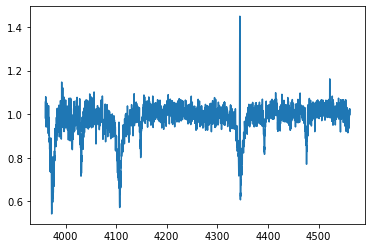

In [4]:
plt.plot(wave[0], flux[1])
# plt.xlim(4330, 4355)
# plt.ylim(0.6, 1.3)

In [5]:
path='./fit_results/'
gaussfit(stars, path=path)


********************************************************************************
******************       Gaussian fitting: star BBC 9       ******************
********************************************************************************

*** SB2:  False  ***

these are the lines:  [4026, 4102, 4144, 4340, 4388, 4471, 4553]


*** Performing 1st fit ***
--------------------------
fitting line  4026
fitting line  4102
fitting line  4144
fitting line  4340
fitting line  4388
fitting line  4471
fitting line  4553
 ...fit done

Ploting line fits...
4026
4102
4144
4340
4388
4471
4553
 ...plots done
 ...fit done
 ...plots done



In [11]:
results = rv(stars, use_lines=[4026, 4144, 4388], balmer=True, epochs_ok_thrsld=3.) # , use_lines=[4144, 4388, 4471]



*******************************************************************************
******************         RV Analisys: star BBC 9         ******************
*******************************************************************************

*** Calculating % errors ***
----------------------------


*** Computing Radial velocities ***
-----------------------------------


*** Choosing the best lines ***
-------------------------------
 Primary:                 4026      4102      4144      4340      4388      4471      4553
   mean(wid1_percer)   [' 9.604', ' 7.004', '10.953', ' 6.878', '13.391', '14.418', '43.021']
   median(wid1_percer) [' 8.021', ' 6.237', ' 8.941', ' 5.528', ' 6.914', ' 7.452', '31.306']
   mean(cen1_percer)   [' 0.004', ' 0.002', ' 0.003', ' 0.002', ' 0.002', ' 0.003', ' 0.004']
   median(cen1_percer) [' 0.003', ' 0.002', ' 0.002', ' 0.002', ' 0.002', ' 0.003', ' 0.004']
   -----------------------------------
   Selecting lines determined by user:

   these are th

In [7]:
def sinu(x, A, w, phi, h):
    "Sinusoidal: sinu(data, amp, freq, phase, height)"
    return A*np.sin(w*(x-phi))+h

def outlier_killer(data, thresh=2, print_output=True):
    ''' returns the positions of elements in a list that
        are not outliers. Based on a median-absolute-deviation
        (MAD) test '''
   # diff = abs(data - np.nanmedian(data))
    diff = data - np.nanmedian(data)
    if print_output==True:
        print('     x-median(x)      =', [f'{x:.3f}' for x in diff])
        print('     abs(x-median(x)) =', [f'{abs(x):.3f}' for x in diff])
    mad = 1.4826*np.nanmedian(abs(diff))
    if print_output==True:
        print('     mad =', f'{mad:.3f}')
        print('     abs(x-median(x)) <', (f'{thresh*mad:.3f}'), '(thresh*mad) =', [x<thresh*mad for x in diff])
    inliers, outliers = [], []
    for i in range(len(data)):
        if diff[i] < thresh*mad:
            inliers.append(i)
        else:
            outliers.append(i)
    return inliers, outliers

def weighted_mean(data, errors):
    weights = [1/(dx**2) for dx in errors]
    mean = sum([wa*a for a,wa in zip(data, weights)])/sum(weights)
    mean_err = np.sqrt(sum( [(da*wa)**2 for da,wa in zip(errors, weights)] ))/sum(weights)
    return mean, mean_err

def rv(idlist, balmer=False, SB2=False, use_lines=None, lines_ok_thrsld=2, epochs_ok_thrsld=2, \
        min_sep=2, print_output=True, random_eps=False, rndm_eps_n=29, rndm_eps_exc=[], plots=True):
    import warnings
    import copy
    import matplotlib
    from astropy.timeseries import LombScargle
    from scipy.signal import find_peaks
    from matplotlib.ticker import StrMethodFormatter
    from iteration_utilities import duplicates, unique_everseen
    warnings.filterwarnings("ignore", message="Font family ['serif'] not found. Falling back to DejaVu Sans.")
    warnings.filterwarnings("ignore", message="Mean of empty slice")
    '''
    Computation of radial velocities and L-S test
    '''
    currentdate = str(date.today())
    periods, frequencies = [], []
    for star in idlist:
        # if len(idlist)>1:
        #     best_lines=None
        if print_output==True:
            print('\n')
            print( '*******************************************************************************' )
            print( '******************         RV Analisys: star BBC '+str(star)+'         ******************' )
            print( '*******************************************************************************\n' )


        # Reading data from fit_states.csv
        path = './fit_results/BBC_'+str(star).zfill(3)+'/'
        datapath = './spectra/BBC_'+str(star).zfill(3)+'/'

        filelist = sorted(glob(datapath+'data/BBC*.dat'))

        df_gfit = pd.read_csv(path+'fit_states.csv')

        x1, dx1, y1, dy1, z1, dz1, lines, chi2, epoch = \
                                                    df_gfit['cen1'], df_gfit['cen1_er'], df_gfit['amp1'], \
                                                    df_gfit['amp1_er'], df_gfit['wid1'], df_gfit['wid1_er'], \
                                                    df_gfit['line'], df_gfit['chisqr'], df_gfit['Epoch']
        if SB2==True:
            x2, dx2, y2, dy2, z2, dz2 = df_gfit['cen2'], df_gfit['cen2_er'], df_gfit['amp2'], \
                                        df_gfit['amp2_er'], df_gfit['wid2'], df_gfit['wid2_er'], \

        lines = list(unique_everseen(duplicates(lines)))
        if print_output==True:
            print( '*** Calculating % errors ***')
            print( '----------------------------')
        cen1_percer, cen2_percer = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        amp1_percer, amp2_percer = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        wid1_percer, wid2_percer = [[] for i in range(len(lines))], [[] for i in range(len(lines))]
        cen_stddev = [[] for i in range(len(lines))]
        amp_stddev = [[] for i in range(len(lines))]
        wid_stddev = [[] for i in range(len(lines))]
        for i in  range(len(lines)):                    # i: num of lines
            for j in range(len(df_gfit)):                    # j: length of fit_states.csv
                if df_gfit['line'][j]==lines[i]:
                    if dx1[j]==0:
                        print('error = 0')
                        sys.exit()
                        cen1_percer[i].append(40)
                    if dy1[j]==0:
                        print('error = 0')
                        sys.exit()
                        amp1_percer[i].append(40)
                    if dz1[j]==0:
                        print('error = 0')
                        sys.exit()
                        wid1_percer[i].append(40)
                    if dx1[j]!=0:
                        cen1_percer[i].append( abs(100*dx1[j]/x1[j])) # dim: n_lines x n_epochs
                    if dy1[j]!=0:
                        amp1_percer[i].append( abs(100*dy1[j]/y1[j]))
                    if dz1[j]!=0:
                        wid1_percer[i].append( abs(100*dz1[j]/z1[j]))
                    cen_stddev[i].append(x1[j])
                    amp_stddev[i].append(y1[j])
                    wid_stddev[i].append(z1[j])
                    if SB2==True:
                        if dx2[j]==0:
                            print('error = 0')
                            sys.exit()
                            cen2_percer[i].append(40)
                        if dy2[j]==0:
                            print('error = 0')
                            sys.exit()
                            amp2_percer[i].append(40)
                        if dz2[j]==0:
                            print('error = 0')
                            sys.exit()
                            wid2_percer[i].append(40)
                        if dx2[j]!=0:
                            cen2_percer[i].append( abs(100*dx2[j]/x2[j])) # dim: n_lines x n_epochs
                        if dy2[j]!=0:
                            amp2_percer[i].append( abs(100*dy2[j]/y2[j]))
                        if dz2[j]!=0:
                            wid2_percer[i].append( abs(100*dz2[j]/z2[j]))
        if print_output==True:
            print( '\n')
            print( '*** Computing Radial velocities ***')
            print( '-----------------------------------')
        c = 2.998*pow(10,5)
        nlines = len(lines)

        lambda_shift1, lambda_shift2 = [[] for i in range(nlines)], [[] for i in range(nlines)]
        lambda_shift1_er, lambda_shift2_er = [[] for i in range(nlines)], [[] for i in range(nlines)]
        for i in  range(nlines):                    # i: num of best lines
            for j in range(len(df_gfit)):                    # j: length of fit_states.csv
                if df_gfit['line'][j]==lines[i]:
                    lambda_shift1[i].append(x1[j])
                    lambda_shift1_er[i].append(dx1[j])
                    if SB2==True:
                        lambda_shift2[i].append(x2[j])
                        lambda_shift2_er[i].append(dx2[j])
        nepochs = len(lambda_shift1[0])
        if balmer==False:
            lambda_r = [4026.1914, 4143.761, 4387.9296, 4471.4802, 4552.62]
            lambda_r_er = [0.0010,    0.010,    0.0006,    0.0015,    0.10]
        elif balmer==True:
            lambda_r = [4026.1914, 4101.734, 4143.761, 4340.472, 4387.9296, 4471.4802, 4552.62]
            lambda_r_er = [0.0010,    0.006,    0.010,    0.006,    0.0006,    0.0015,    0.10]

        #print(lambda_r)
        #lambda_r = [4026.275, 4143.759, 4199.830, 4387.928, 4471.477, 4541.590, 4552.654]
        #lambda_rest  = [lambda_r[y] for y in best_lines_index]
        lambda_rest  = lambda_r
        #print(lambda_rest)
        rvs1, rvs1_er  = [[] for i in range(nlines)], [[] for i in range(nlines)]
        rvs2, rvs2_er  = [[] for i in range(nlines)], [[] for i in range(nlines)]
        for i in range(nlines): # num of lines
            for j in range(nepochs): # num of epochs
                dlambda1 = abs(lambda_shift1[i][j] - lambda_rest[i])
                dlambda1_er = np.sqrt( lambda_shift1_er[i][j]**2 + lambda_r_er[i]**2 )
                rvs1[i].append( dlambda1*c/lambda_rest[i]  )
                rvs1_er[i].append( np.sqrt( (dlambda1_er/dlambda1)**2 + (lambda_r_er[i]/lambda_rest[i])**2 )*rvs1[i][j] )
                if SB2==True:
                    dlambda2 = abs(lambda_shift2[i][j] - lambda_rest[i])
                    dlambda2_er = np.sqrt( lambda_shift2_er[i][j]**2 + lambda_r_er[i]**2 )
                    rvs2[i].append( dlambda2*c/lambda_rest[i]  )
                    rvs2_er[i].append( np.sqrt( (dlambda2_er/dlambda2)**2 + (lambda_r_er[i]/lambda_rest[i])**2 )*rvs2[i][j] )
        if print_output==True:
            print( '\n')
            print( '*** Choosing the best lines ***')
            print( '-------------------------------')

        # errors plots
        bins=range(0,800,10)
        if plots==True:
            if not os.path.exists(path+'errors'):
                os.makedirs(path+'errors')
            for i in range(nlines):
                fig, ax = plt.subplots(figsize=(8, 6))
                fig.subplots_adjust(left=0.11, right=0.91, top=0.96, bottom=0.11)
                y, x, _ = plt.hist(wid1_percer[i], bins=bins, histtype='stepfilled', density=False, linewidth=0.5)
                plt.axvline(np.nanmean(wid1_percer[i]), c='orange', ls='--', label='mean='+str(f'{np.nanmean(wid1_percer[i]):.1f}'))
                plt.axvline(np.nanmedian(wid1_percer[i]), c='blue', ls='--', label='median='+str(f'{np.nanmedian(wid1_percer[i]):.1f}'))
                plt.legend()
                plt.savefig(path+'errors/wid_histo_'+str(lines[i])+'.pdf')
                plt.close()
            for i in range(nlines):
                fig, ax = plt.subplots(figsize=(8, 6))
                fig.subplots_adjust(left=0.11, right=0.91, top=0.96, bottom=0.11)
                y, x, _ = plt.hist(amp1_percer[i], bins=bins, histtype='stepfilled', density=False, linewidth=0.5)
                plt.axvline(np.nanmean(amp1_percer[i]), c='orange', ls='--', label='mean='+str(f'{np.nanmean(amp1_percer[i]):.1f}'))
                plt.axvline(np.nanmedian(amp1_percer[i]), c='blue', ls='--', label='median='+str(f'{np.nanmedian(amp1_percer[i]):.1f}'))
                plt.legend()
                plt.savefig(path+'errors/amp_histo_'+str(lines[i])+'.pdf')
                plt.close()
            for i in range(nlines):
                fig, ax = plt.subplots(figsize=(8, 6))
                fig.subplots_adjust(left=0.11, right=0.91, top=0.96, bottom=0.11)
                y, x, _ = plt.hist(cen1_percer[i], bins=bins, histtype='stepfilled', density=False, linewidth=0.5)
                plt.axvline(np.nanmean(cen1_percer[i]), c='orange', ls='--', label='mean='+str(f'{np.nanmean(cen1_percer[i]):.1f}'))
                plt.axvline(np.nanmedian(cen1_percer[i]), c='blue', ls='--', label='median='+str(f'{np.nanmedian(cen1_percer[i]):.1f}'))
                plt.legend()
                plt.savefig(path+'errors/cen_histo_'+str(lines[i])+'.pdf')
                plt.close()

        # print table with means and medians
        if print_output==True:
            for i in range(nlines):
                if i == 0:
                    print(' Primary:                ', str(lines[i]), end='')
                elif i<range(nlines)[-1]:
                    print('     ', str(lines[i]), end='')
                else:
                    print('     ', str(lines[i]))
            print('   mean(wid1_percer)  ', [str(f'{np.nanmean(x):6.3f}') for x in wid1_percer])
            print('   median(wid1_percer)', [str(f'{np.nanmedian(x):6.3f}') for x in wid1_percer])
            print('   mean(cen1_percer)  ', [str(f'{np.nanmean(x):6.3f}') for x in cen1_percer])
            print('   median(cen1_percer)', [str(f'{np.nanmedian(x):6.3f}') for x in cen1_percer])
            # print('   mean(amp1_percer)', [str(f'{np.nanmean(x):.3f}') for x in amp1_percer])
            # print('   median(amp1_percer)', [str(f'{np.nanmedian(x):.3f}') for x in amp1_percer])
            if SB2==True:
                print(' Secondary:')
                print('   mean(wid2_percer)  ', [str(f'{np.nanmean(x):6.3f}') for x in wid2_percer])
                print('   median(wid2_percer)', [str(f'{np.nanmedian(x):6.3f}') for x in wid2_percer])
                print('   mean(cen2_percer)  ', [str(f'{np.nanmean(x):6.3f}') for x in cen2_percer])
                print('   median(cen2_percer)', [str(f'{np.nanmedian(x):6.3f}') for x in cen2_percer])
                # print('   mean(amp2_percer)', [np.nanmean(x) for x in amp2_percer])
                # print('   median(amp2_percer)', [np.nanmedian(x) for x in amp2_percer])

        '''
        Writing stats to file rv_stats
        '''
        out = open(path+'rv_stats.dat', 'w')
        out.write(' ********************\n')
        out.write('       BBC '+str(star)+'\n')
        out.write(' ********************\n')
        out.write('\n')
        out.write(' Mean of percentual errors'+'\n')
        out.write('   Lines '+'  amp1  '+'  wid1  '+' cen1 '+'  |  '+'  amp2  '+'  wid2  '+' cen2 '+'\n')
        out.write('   -------------------------------------------------------'+'\n')
        for i in range(nlines):
            out.write('   '+str(lines[i])+': '+str(f'{np.nanmean(amp1_percer[i]):7.3f}')+' '+str(f'{np.nanmean(wid1_percer[i]):7.3f}')+'  '+str(f'{np.nanmean(cen1_percer[i]):5.3f}')+'  |  '+\
                                               str(f'{np.nanmean(amp2_percer[i]):7.3f}')+' '+str(f'{np.nanmean(wid2_percer[i]):7.3f}')+'  '+str(f'{np.nanmean(cen2_percer[i]):5.3f}')+'\n')
        out.write('\n')
        out.write(' Median of percentual errors'+'\n')
        out.write('   Lines '+'  amp1  '+'  wid1  '+' cen1 '+'  |  '+'  amp2  '+'  wid2  '+' cen2 '+'\n')
        out.write('   -------------------------------------------------------'+'\n')
        for i in range(nlines):
            out.write('   '+str(lines[i])+': '+str(f'{np.nanmedian(amp1_percer[i]):7.3f}')+' '+str(f'{np.nanmedian(wid1_percer[i]):7.3f}')+'  '+str(f'{np.nanmedian(cen1_percer[i]):5.3f}')+'  |  '+\
                                               str(f'{np.nanmedian(amp2_percer[i]):7.3f}')+' '+str(f'{np.nanmedian(wid2_percer[i]):7.3f}')+'  '+str(f'{np.nanmedian(cen2_percer[i]):5.3f}')+'\n')
        '''
        Selecting the linestyle
        '''
        if not use_lines:
            if print_output==True:
                print('   --------------------------------------------')
                print('   Applying outlier_killer to remove bad lines:')
                # print('   # use_lines is empty')
            best_lines_index, rm_lines_idx = outlier_killer([np.nanmedian(x) for x in wid1_percer], lines_ok_thrsld, print_output=print_output)
            # best_lines_index, rm_lines_idx = outlier_killer([np.nanmedian(x) for x in cen1_percer], lines_ok_thrsld, print_output=print_output)
            best_lines = [lines[x] for x in best_lines_index]
            if print_output==True:
                print('\n   these are the best lines: ', best_lines)
        else:
            if print_output==True:
                print('   -----------------------------------')
                print('   Selecting lines determined by user:')
                # print('   # use_lines is NOT empty')
            best_lines_index = [i for i,x in enumerate(lambda_r) if any(round(x)==line for line in use_lines)]
            rm_lines_idx = [i for i,x in enumerate(lambda_r) if all(round(x)!=line for line in use_lines)]
            best_lines = [lines[x] for x in best_lines_index]
            if print_output==True:
                print('\n   these are the best lines: ', best_lines)

        nlines = len(best_lines)

        out.write('\n')
        out.write(' Lines with the best fitted profile according to the median wid1 criterion:\n')
        out.write(' --------------------------------------------------------------------------\n')
        for i in range(nlines):
            if i<range(nlines)[-1]:
                out.write('   '+str(best_lines_index[i])+': '+str(best_lines[i])+', ')
            else:
                out.write('   '+str(best_lines_index[i])+': '+str(best_lines[i])+'\n')
        out.write('\n')

        # for i in reversed(rm_lines_idx):
               # print(i)
            # del lambda_shift1[i]
            # del lambda_shift2[i]
            # del lambda_shift1_er[i]
            # del lambda_shift2_er[i]
            # del rvs1[i]
            # del rvs1_er[i]

        # sys.exit()
        if SB2==True:
            if print_output==True:
                print( '\n')
                print( '*** Choosing best epochs for SB2 analysis ***')
                print( '---------------------------------------------')

            # selecting epochs with larger separation between components
            delta_cen, best_OBs = [[] for i in range(nlines)], [[] for i in range(nlines)]
            if not min_sep:
                min_sep = 1.2 # higher = relaxed
            for i, k in zip(range(nlines), best_lines_index):
                for j in range(nepochs):
                    # print(best_lines[i], 'epoch', j+1, abs(lambda_shift1[i][j]-lambda_shift2[i][j]))
                    delta_cen[i].append(abs(lambda_shift1[k][j]-lambda_shift2[k][j]))
            for i, k in zip(range(nlines), best_lines_index):
                for j in range(nepochs):

                    if abs(lambda_shift1[k][j]-lambda_shift2[k][j]) > np.mean(delta_cen[i])-min_sep:
                        best_OBs[i].append(j)
            common_OB = set(best_OBs[0])
            for OB in best_OBs[1:]:
                common_OB.intersection_update(OB)
            common_OB = list(common_OB)
            wrong_OB = [x for x in range(nepochs) if not x in common_OB]
            if print_output==True:
                # print('   mean(Delta')
                print('   Epochs with components separation >', [f'{np.mean(x)-min_sep:.3f}' for x in delta_cen])
                print('  ', [x+1 for x in common_OB])
                print('   removed epochs: '+str([x+1 for x in wrong_OB]))
            out.write(' Epochs with components separation > '+ f'{np.mean(delta_cen[i])-min_sep:.3f}'+':'+'\n')
            out.write('   '+str([x+1 for x in common_OB])+'\n')
            out.write('   removed epochs: '+str([x+1 for x in wrong_OB])+'\n')
            out.write('\n')

            # removing epochs with inverted components
            # print('wrong_OB:', wrong_OB)
            for j in common_OB:
                temp_OB =[]
                for i in best_lines_index:
                    # if j==20:
                    #     print(lines[i], 'epoch', j+1, lambda_shift1[i][j], lambda_shift2[i][j], lambda_shift1[i][j]-lambda_shift2[i][j])
                    temp_OB.append(lambda_shift1[i][j]-lambda_shift2[i][j])
                if not all(x>0 for x in temp_OB) and not all(x<0 for x in temp_OB):
                    wrong_OB.append(j)
            # print('wrong_OB:', wrong_OB)
            oldOBs = copy.deepcopy(common_OB)
            for j in range(len(common_OB)-1, -1, -1):
                if common_OB[j] in wrong_OB:
                    del common_OB[j]
            if print_output==True:
                print('   --------')
                print('   Removing epochs with inverted components:')
                print('   Best epochs:', [x+1 for x in common_OB])
                print('   removed epochs:'+str([x+1 for x in oldOBs if x not in common_OB]))
            out.write(' Removing epochs with inverted components:'+'\n')
            out.write('   removed epochs:'+str([x+1 for x in oldOBs if x not in common_OB])+'\n')
            out.write('   Best epochs:'+str([x+1 for x in common_OB])+'\n')
            out.write('\n')

            # removing bad/noisy epochs
            mean_amp1_er, mean_cen1_er = [], []
            if print_output==True:
                print('   --------')
                print('   Removing epochs with large errors:')
            out.write(' Removing epochs with large errors:'+'\n')
            for j in common_OB:
                temp_wid1, temp_cen1 = [], []
                for i in best_lines_index:
                    #print(lines[i], 'epoch', j+1, wid1_percer[i][j])
                #    temp_wid1.append(wid1_percer[i][j])
                # if all(np.isnan(x)==False for x in temp_wid1):
                #    print('     epoch', j+1, 'mean(wid1_percer)', np.nanmean(temp_wid1))
                #    mean_amp1_er.append(np.nanmean(temp_wid1))
                # else:
                #    print('     epoch', j+1, 'mean(wid1_percer)', 'nan')
                #    mean_amp1_er.append(np.nan)
                    temp_cen1.append(lambda_shift1_er[i][j])
                if all(np.isnan(x)==False for x in temp_cen1):
                    if print_output==True:
                        print('     epoch', j+1, 'mean(cen1_percer)', np.nanmean(temp_cen1))
                    out.write('   epoch '+str(f'{j+1:2}')+' mean(cen1_percer) = '+str(f'{np.nanmean(temp_cen1):.3f}')+'\n')
                    mean_cen1_er.append(np.nanmean(temp_cen1))
                else:
                    if print_output==True:
                        print('     epoch', j+1, 'mean(cen1_percer)', 'nan')
                    out.write('   epoch '+str(f'{j+1:2}')+' mean(cen1_percer) = '+'nan'+'\n')
                    mean_cen1_er.append(np.nan)
            if print_output==True:
                print('   Applying outlier_killer to remove epochs')
            # rm_OBs_idx = outlier_killer(mean_amp1_er, 2)[1]
            rm_OBs_idx = outlier_killer(mean_cen1_er, epochs_ok_thrsld, print_output=print_output)[1]

           # print('rm_OBs_idx:', rm_OBs_idx)
            if print_output==True:
                print('   epochs removed: '+str([common_OB[x]+1 for x in rm_OBs_idx]))
            out.write('   epochs removed: '+str([common_OB[x]+1 for x in rm_OBs_idx])+'\n')
            out.write('\n')
            for i in reversed(rm_OBs_idx):
                wrong_OB.append(common_OB[i])
                del common_OB[i]
            best_OBs = common_OB
            # best_OBs0 = [2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18, 19, 25, 26, 28]
            # best_OBs = [x-1 for x in best_OBs0]

        else: # if SB2==False
            '''
            for SB1s
            '''
            if print_output==True:
                print( '\n')
                print( '*** Choosing best epochs for SB1 analysis ***')
                print( '---------------------------------------------')
            OBs_list = list(range(nepochs))

            if random_eps==True:
                import random
                if rndm_eps_exc:
                    OBs_list = [x for x in OBs_list if x not in rndm_eps_exc]
                # print(sorted(np.random.choice(OBs_list, size=20, replace=False)))
                # OBs_list = [x for x in OBs_list if x not in (9, 11, 12, 23)]
                best_OBs = sorted(np.random.choice(OBs_list, size=rndm_eps_n, replace=False))
                print(OBs_list, best_OBs)
                wrong_OB = [x for x in OBs_list if x not in best_OBs]+rndm_eps_exc
                print(wrong_OB)
            else:
                # removing bad/noisy epochs
                mean_amp1_er, mean_cen1_er, mean_wid1_er, mean_rvs1_er = [], [], [], []
                if print_output==True:
                    print('   --------')
                    print('   Removing epochs with large errors:')
                out.write(' Removing epochs with large errors:'+'\n')
                for j in OBs_list:
                    temp_wid1, temp_cen1, temp_amp1, temp_rvs1 = [], [], [], []
                    for i in best_lines_index:
                        # print(lines[i], 'epoch', j+1, wid1_percer[i][j])
                   #     temp_wid1.append(wid1_percer[i][j])
                   # print('epoch', j+1, 'mean(wid1_percer)', np.nanmean(temp_wid1))
                   # mean_amp1_er.append(np.nanmean(temp_wid1))
                        temp_wid1.append(wid1_percer[i][j])
                        temp_cen1.append(cen1_percer[i][j])
                        temp_amp1.append(amp1_percer[i][j])
                        temp_rvs1.append(100*rvs1_er[i][j]/rvs1[i][j])
                    if all(np.isnan(x)==False for x in temp_wid1):
                        mean_wid1_er.append(np.nanmean(temp_wid1))
                    else:
                        mean_wid1_er.append(np.nan)
                    if all(np.isnan(x)==False for x in temp_cen1):
                        mean_cen1_er.append(np.nanmean(temp_cen1))
                    else:
                        mean_cen1_er.append(np.nan)
                    if all(np.isnan(x)==False for x in temp_amp1):
                        mean_amp1_er.append(np.nanmean(temp_amp1))
                    else:
                        mean_amp1_er.append(np.nan)
                    if all(np.isnan(x)==False for x in temp_rvs1):
                        mean_rvs1_er.append(np.nanmean(temp_rvs1))
                    else:
                        mean_rvs1_er.append(np.nan)
                    if print_output==True:
                        print('     epoch', f'{j+1:2}', ' mean(cen1_%er) =', f'{np.nanmean(temp_cen1):6.4f}', ' mean(wid1_%er) =', f'{np.nanmean(temp_wid1):4.1f}', \
                                                        ' mean(amp1_%er) =', f'{np.nanmean(temp_amp1):4.1f}', ' mean(rvs1_%er) =', f'{np.nanmean(temp_rvs1):4.1f}')
                    out.write('     epoch'+ str(f'{j+1:2}')+ ' mean(cen1_%er) ='+ str(f'{np.nanmean(temp_cen1):6.4f}')+ \
                                                             ' mean(wid1_%er) ='+ str(f'{np.nanmean(temp_wid1):4.1f}')+ \
                                                             ' mean(amp1_%er) ='+ str(f'{np.nanmean(temp_amp1):4.1f}')+ \
                                                             ' mean(rvs1_%er) ='+ str(f'{np.nanmean(temp_rvs1):4.1f}')+'\n')
                if print_output==True:
                    print('   Applying outlier_killer to remove epochs')
                rm_OBs_idx = outlier_killer(mean_wid1_er, epochs_ok_thrsld, print_output=print_output)[1]
                # rm_OBs_idx = outlier_killer(mean_rvs1_er, epochs_ok_thrsld, print_output=print_output)[1]
                # rm_OBs_idx = outlier_killer(mean_amp1_er, 1)[1]
                # rm_OBs_idx = outlier_killer(mean_cen1_er, 1)[1]
                if print_output==True:
                    print('   epochs removed: '+str([OBs_list[x]+1 for x in rm_OBs_idx]))

                out.write('\n   epochs removed: '+str([OBs_list[x]+1 for x in rm_OBs_idx])+'\n')
                out.write('\n')
                for i in reversed(rm_OBs_idx):
                    del OBs_list[i]
                best_OBs = OBs_list
                wrong_OB = rm_OBs_idx

        for i in reversed(rm_lines_idx):
               # print(i)
                del lambda_shift1[i]
                del lambda_shift1_er[i]
                del rvs1[i]
                del rvs1_er[i]
                if SB2==True:
                    del lambda_shift2[i]
                    del lambda_shift2_er[i]
                    del rvs2[i]
                    del rvs2_er[i]

        # best_OBs0 = [1, 2, 3, 4, 5, 6, 8, 9, 11, 15, 17, 18, 19, 21, 22, 25, 27, 28]
        # best_OBs = [x-1 for x in best_OBs0]

        nepochs_0 = copy.deepcopy(nepochs)
        nepochs = len(best_OBs)
        rm_OBs_idx = sorted(wrong_OB)
        # rm_OBs_idx = [8, 9, 10, 11, 12, 13, 17, 21, 23, 26, 27]
        # rm_OBs_idx = [7, 10, 12, 13, 14, 16, 20, 23, 24, 26, 29]
        # rm_OBs_idx = [x-1 for x in rm_OBs_idx]
        # Printing/Writing final epochs
        # print('wrong_OB', rm_OBs_idx)
        if print_output==True:
            print('   ------------------')
            print('   Final best epochs:', [x+1 for x in best_OBs])
            print('   Number of epochs:', nepochs)
        out.write(' Final best epochs: '+str([x+1 for x in best_OBs])+'\n')
        out.write(' Number of epochs: '+str(nepochs)+'\n')
        out.write('\n')

        ########################################################################
        '''

        '''
        if print_output==True:
            print( '\n')
            print( '*** Calculating the RV weighted mean for each epoch  ***')
            print( '--------------------------------------------------------')
        rv_list1 = list(map(list, zip(*rvs1))) # nlinesxnepochs (6x26) -> nepochsxnlines (26x6)
        rv_list1_er = list(map(list, zip(*rvs1_er)))
        if SB2==True:
            rv_list2 = list(map(list, zip(*rvs2))) # nlinesxnepochs (6x26) -> nepochsxnlines (26x6)
            rv_list2_er = list(map(list, zip(*rvs2_er)))
        # removing bad epochs from the list of radial velocities
        for j in range(nepochs_0-1, -1, -1):
            if not j in best_OBs:
                del rv_list1[j]
                del rv_list1_er[j]
                if SB2==True:
                    del rv_list2[j]
                    del rv_list2_er[j]
        # print(rv_list1)
        # print(rv_list2)
        # print(rv_list2_er)
        sigma_rv1, sigma_rv2 = [], []
        mean_rv1, wmean_rv1, mean_rv1_er, wmean_rv1_er = [], [], [], []
        mean_rv2, wmean_rv2, mean_rv2_er, wmean_rv2_er = [], [], [], []
        for i in range(nepochs): # i: 0 -> num of epochs
            sigma_rv1.append(np.std(rv_list1[i])) # std dev of the RVs for each epoch
            # arithmetic mean
            # mean_rv.append(np.mean(rv_list1[i])) # mean RV for each epoch
            # rv_list_sqr = [x**2 for x in rv_list1_er[i]]
            # mean_rv_er.append( np.sqrt( sum(rv_list_sqr) )/len(rv_list_sqr)) # error of the mean RV
            # weighted mean
            mean1, mean1_er = weighted_mean(rv_list1[i], rv_list1_er[i])
            wmean_rv1.append(mean1)
            wmean_rv1_er.append(mean1_er)
            if SB2==True:
                sigma_rv2.append(np.std(rv_list2[i])) # std dev of the RVs for each epoch
                mean2, mean2_er = weighted_mean(rv_list2[i], rv_list2_er[i])
                wmean_rv2.append(mean2)
                wmean_rv2_er.append(mean2_er)
        sigma_tot1 = np.std(sigma_rv1)
        sigma_er_tot1 = np.std(wmean_rv1_er)
        if SB2==True:
            sigma_tot2 = np.std(sigma_rv2)
            sigma_er_tot2 = np.std(wmean_rv2_er)

        # Coming back to nlines x nepochs without the removed epochs
        # to calculate a mean RV for each line
        rvs1 = list(map(list, zip(*rv_list1)))
        rvs1_er = list(map(list, zip(*rv_list1_er)))
        if SB2==True:
            rvs2 = list(map(list, zip(*rv_list2)))
            rvs2_er = list(map(list, zip(*rv_list2_er)))
        ep_avg1, ep_avg1_er = [], []
        ep_avg2, ep_avg2_er = [], []
        for i in range(nlines):
            # arithmetic mean
            ep_avg1.append(np.mean(rvs1[i])) # this is the mean RV of all epochs for each line
            ep_avg1_sqr = [x**2 for x in rvs1_er[i]]
            ep_avg1_er.append( np.sqrt( sum(ep_avg1_sqr) ) / len(ep_avg1_sqr) )
            #ep_avg1_er.append( np.sqrt( sum(ep_avg1_sqr)/(len(ep_avg1_sqr)-1) ) / np.sqrt(len(ep_avg1_sqr)) )
            if SB2==True:
                ep_avg2.append(np.mean(rvs2[i])) # this is the mean of all epochs for each line
                ep_avg2_sqr = [x**2 for x in rvs2_er[i]]
                ep_avg2_er.append( np.sqrt( sum(ep_avg2_sqr) ) / len(ep_avg2_sqr) )

        total_mean_rv1, total_mean_rv1_er = weighted_mean(wmean_rv1, wmean_rv1_er)
        if SB2==True:
            total_mean_rv2, total_mean_rv2_er = weighted_mean(wmean_rv2, wmean_rv2_er)
        # Printing/Writing
        if print_output==True:
            print('\n RV mean of the ',str(nepochs),' epochs for each line:')
            print(' -----------------------------------------')
            for i in range(nlines):                              # f'{a:.2f}
                #out.write('   - '+str(best_lines[i])+': '+str(f'{ep_avg1[i]:.3f}')+'\n')
                print('   - ',str(best_lines[i]),': ',str(f'{ep_avg1[i]:.3f}'),' +/- ',str(f'{ep_avg1_er[i]:.3f}'))
            print('\n')
            print(' Weighted mean RV of the ',str(nepochs),' epochs:')
            print(' -------------------------')
            print('   ', 'Primary  : ',str( f'{total_mean_rv1:.3f}' ),' +/- ',str( f'{total_mean_rv1_er:.3f}' ) ,\
                ', std dev = ', str(f'{sigma_tot1:.3f}'))
            if SB2==True:
                print('   ', 'Secondary: ',str( f'{total_mean_rv2:.3f}' ),' +/- ',str( f'{total_mean_rv2_er:.3f}' ) ,\
                    ', std dev = ', str(f'{sigma_tot2:.3f}'))
            print('\n')
        out.write(' RV mean of the '+str(nepochs)+' epochs for each line: \n')
        out.write(' ---------------------------------------\n')
        for i in range(nlines):                              # f'{a:.2f}
            #out.write('   - '+str(best_lines[i])+': '+str(f'{ep_avg1[i]:.3f}')+'\n')
            out.write('   - '+str(best_lines[i])+': '+str(f'{ep_avg1[i]:.3f}')+' +/- '+str(f'{ep_avg1_er[i]:.3f}')+'\n')
        out.write('\n')
        out.write(' Weighted mean RV of the '+str(nepochs)+' epochs:\n')
        out.write('------------------------------------------\n')
        #out.write('   '+str(np.mean(mean_rv))+' +/- '+str(sigma_tot)+' (std dev)\n')
        out.write('   '+str( f'{total_mean_rv1:.3f}' )+' +/- '+ str( f'{total_mean_rv1_er:.3f}' ) +\
            ', std dev = '+ str(f'{sigma_tot1:.3f}')+'\n')
        out.write('\n')
        out.close()

        #####################################################################

        '''
        Writing RVs to file RVs.dat
        '''
        df_rv = pd.read_csv('spectra/BBC_009/JDs.dat', names = ['BBC_epoch', 'HJD'], sep='\t')
        df_rv = df_rv.replace({'BBC_':''}, regex=True).replace({'.fits':''}, regex=True)
        if not len(rm_OBs_idx)==0:
            df_rv.drop(rm_OBs_idx, inplace=True)
            df_rv.reset_index(inplace=True)
        for i in range(nlines):
            df_rv['rv_'+str(best_lines[i])] = rvs1[i]
            df_rv['rv_'+str(best_lines[i])+'_er'] = rvs1_er[i]
        df_rv['mean_rv'] = wmean_rv1
        df_rv['mean_rv_er'] = wmean_rv1_er
        df_rv['sigma_rv'] = sigma_rv1
        #df_rv.to_csv(path+'RVs.dat', sep='\t', index=False)
        with open(path+'RVs1.dat', 'w') as fo:
            #fo.write(df_rv.to_string(formatters={'mean_rv':'{:.25f}'.format}, index=False))
            fo.write(df_rv.to_string(formatters={'HJD': '{:.8f}'.format}, index=False))
        if SB2==True:
            df_rv2 = pd.read_csv(path+'JDs.dat', names = ['BBC_epoch', 'HJD'], sep='\t')
            df_rv2 = df_rv2.replace({'BBC_':''}, regex=True).replace({'.fits':''}, regex=True)
            if not len(rm_OBs_idx)==0:
                df_rv2.drop(rm_OBs_idx, inplace=True)
                df_rv2.reset_index(inplace=True)
            for i in range(nlines):
                df_rv2['rv_'+str(best_lines[i])] = rvs2[i]
                df_rv2['rv_'+str(best_lines[i])+'_er'] = rvs2_er[i]
            df_rv2['mean_rv'] = wmean_rv2
            df_rv2['mean_rv_er'] = wmean_rv2_er
            df_rv2['sigma_rv'] = sigma_rv2
            #df_rv.to_csv(path+'RVs.dat', sep='\t', index=False)
            with open(path+'RVs1.dat', 'a') as fo:
                #fo.write(df_rv.to_string(formatters={'mean_rv':'{:.25f}'.format}, index=False))
                fo.write('\n')
                fo.write('Secondary:\n')
                fo.write(df_rv2.to_string(formatters={'HJD': '{:.8f}'.format}, index=False))

        #####################################################################

        '''
        Lomb-Scargle
        '''
        if print_output==True:
            print( '*** Computing L-S ***')
            print( '---------------------')
        if not os.path.exists(path+'LS'):
            os.makedirs(path+'LS')
        lsout = open(path+'LS/ls_output.txt', 'w')
        lsout.write(' *************************\n')
        lsout.write('   LS output for BBC '+str(star)+'\n')
        lsout.write(' *************************\n')
        lsout.write('\n')
        probabilities = [0.5, 0.01, 0.001]
        #ls = LombScargle(df_rv['HJD'], df_rv['mean_rv'], df_rv['sigma_rv'])
        ls1 = LombScargle(df_rv['HJD'], df_rv['mean_rv'], df_rv['mean_rv_er'], normalization='model')
        #method = 'baluev'
        method = 'bootstrap'
        fal1 = ls1.false_alarm_level(probabilities, method=method)
        if print_output==True:
            print('   these are the false alarm levels: ', [f'{x:.3f}' for x in fal1])
        lsout.write(' these are the false alarm levels: ')
        for fal in fal1:
            lsout.write(str(f'{fal:.3f}')+'  ')
        lsout.write('\n')

        frequency1, power1 = ls1.autopower(method='fast', minimum_frequency=0.001, #0.001=1000
                                                    maximum_frequency=2.5, # 0.9=1.1, 1.5=0.67, 2=0.5, 4=0.25
                                                    samples_per_peak=2000) # 2000
        fap1 = ls1.false_alarm_probability(power1.max(), method=method)
        fapper1 = fap1*100
        if print_output==True:
            print('   FAP of the highest peak         : ', f'{fapper1:.5f}')
        lsout.write(' FAP of the highest peak         : '+ f'{fapper1:.5f}'+'\n')

        max_freq1 = frequency1[np.argmax(power1)]
        # print('max_freq1 =', max_freq1)
        peaks_min_h = float(f'{0.8*fal1[1]:.3f}')
        # print(peaks_min_h)
        peaks1, _ = find_peaks(power1, height=peaks_min_h, distance=15000)
        # peaks1, _ = find_peaks(power1, height=0.8*fal1[1], distance=20000) # height=0.8*fal1[1], distance=20000
        # peaks1, _ = find_peaks(power1, height=0.5*fal1[2], distance=1000) # height=0.8*fal1[1], distance=20000
        freq1 = frequency1[peaks1]
        peri1 = 1/frequency1[peaks1]

        if 1/max_freq1 < 1.1 and any(1/freq1 > 1.1):
            for i in range(len(1/freq1)):
                if 1/freq1[i]==max(1/freq1):
                    best_freq1 = freq1[i]
                    LS_power1 = power1[peaks1][i]
        else:
            best_freq1 = max_freq1
            LS_power1 = max(power1)
        best_period1 = 1/best_freq1
        # print('freq1 =', freq1)
        # print('peri1 =', peri1)
        # print('best_freq1 =', best_freq1)
        # print('best_period1 =', best_period1)

        if len(peri1)>0:
            max_peri1 = max(peri1)
            max_peri1_idx = peri1.tolist().index(max_peri1)
            # print('max_peri_idx', max_peri_idx)
            max_peri1_pow = power1[peaks1][max_peri1_idx]
            # print('max_peri_pow', max_peri_pow)
            # print('fal[1]/max_peri_pow', fal[1]/max_peri_pow)
            allP = sorted(peri1)
        if len(peri1)==0:
            allP = [best_period1]

        periods.append(1/frequency1[peaks1])
        frequencies.append(frequency1[peaks1])

        if SB2==True:
            ls2 = LombScargle(df_rv2['HJD'], df_rv2['mean_rv'], df_rv2['mean_rv_er'], normalization='model')
            fal2 = ls2.false_alarm_level(probabilities, method=method)
            frequency2, power2 = ls2.autopower(method='fast', minimum_frequency=0.001, #0.001=1000
                                                        maximum_frequency=2.5, # 0.9=1.1, 1.5=0.67, 2=0.5
                                                        samples_per_peak=2000)
            fap2 = ls2.false_alarm_probability(power2.max(), method=method)
            fapper2 = fap2*100
            LS_power2 = max(power2)
            best_freq2 = frequency2[np.argmax(power2)]
            best_period2 = 1/best_freq2
            peaks2_min_h = float(f'{0.8*fal1[1]:.3f}')
            # print(peaks2_min_h)
            peaks2, _ = find_peaks(power2, height=peaks2_min_h, distance=20000) # distance=20000
            # peaks2, _ = find_peaks(power2, height=0.5*fal2[2], distance=1000) # distance=20000
            peri2 = 1/frequency2[peaks2]
            freq2 = frequency2[peaks2]
            if best_period2 < 1.1:
                if print_output==True:
                    print('\n')
                    print('   ### Warning: Secondary period possible alias, selecting most similar period to P$\_$1')
                    print('\n')
                lsout.write(' ### Warning: Secondary period possible alias, selecting most similar period to P$\_$1 \n')
                dif = []
                for i in range(len(freq2)):
                    dif.append(np.abs(best_freq1-freq2[i]))
                for i in range(len(freq2)):
                    if np.abs(best_freq1-freq2[i]) == np.min(dif):
                        best_freq2   = freq2[i]
                        best_period2 = 1/freq2[i]


        # print("   number of periods               :  {0}".format(len(frequency1)))
        if print_output==True:
            print("   Best frequency                  :  {0:.3f}".format(best_freq1))
            print('   ***********************************************')
            print("   Best Period                     :  {0:.8f} days".format(best_period1))
            print('   ***********************************************')
            if SB2==True:
                print("   Best Period from secondary      :  {0:.8f} days".format(best_period2))

            print('   Other periods:')
            print('     peaks                         : ', [f'{x:.3f}' for x in power1[peaks1]])
            # print('/////////////// these are the periods', periods)
            print('     frequencies                   : ', [f'{x:.5f}' for x in freq1])
            print('     periods                       : ', [f'{x:.3f}' for x in peri1])
            if SB2==True:
                print('   from secondary:')
                print('     peaks                         : ', [f'{x:.3f}' for x in power2[peaks2]])
                print('     frequencies                   : ', [f'{x:.3f}' for x in freq2])
                print('     periods                       : ', [f'{x:.3f}' for x in peri2])

        lsout.write("\n Best frequency                  :  {0:.3f}".format(best_freq1)+'\n')
        lsout.write(' ****************************************************'+'\n')
        lsout.write(" Best Period                     :  {0:.8f} days".format(best_period1)+'\n')
        lsout.write(' ****************************************************'+'\n')
        if SB2==True:
            lsout.write(" Best Period from secondary      :  {0:.8f} days".format(best_period2)+'\n')

        lsout.write(' Other periods:'+'\n')
        lsout.write('   peaks                         : ')
        for peak in power1[peaks1]:
            lsout.write('     '+f'{peak:7.3f}')
        lsout.write('\n   frequencies                   : ')
        for freq in freq1:
            lsout.write('     '+f'{freq:7.3f}')
        lsout.write('\n   periods                       : ')
        for per in peri1:
            lsout.write('     '+f'{per:7.3f}')
        if SB2==True:
            lsout.write('\n from secondary:\n')
            lsout.write('   peaks                         : ')
            for peak in power2[peaks2]:
                lsout.write('     '+f'{peak:7.3f}')
            lsout.write('\n   frequencies                   : ')
            for freq in freq2:
                lsout.write('     '+f'{freq:7.3f}')
            lsout.write('\n   periods                       : ')
            for per in peri2:
                lsout.write('     '+f'{per:7.3f}')
        lsout.write('\n')
        # print(freq[2]-freq[1], freq[0])
        # print('beat period (f2-f1) = ',2*(freq[2]-freq[1]))
        # print('beat period (f1-f0) = ',(freq[1]-freq[0]))
        # print('beat period (f3-f2) = ',(freq[3]-freq[2]))
        # print('beat period 2/(f2-f1) = ',2/(freq[2]-freq[1]))
        # print("Best Period: {0:.8f} days".format(best_period))

       # print('allP: ', allP)
        #print('number of local maxima: '+str(len(mm[0])))
        #yy = [power[i] for i in mm]
        indi = []
        for LS_pow, peri in zip(power1[peaks1], peri1):

            maxpower_maxfal = fal1[2]/LS_pow
            maxpower_maxfal2 = fal1[1]/LS_pow
            if print_output==True:
                print('   fal1/P                          : ', f'{maxpower_maxfal:.2f}')
                print('   fal2/P                          : ', f'{maxpower_maxfal2:.2f}')
                # print('fal1[2]/LS_pow :', fal1[2], '/', LS_pow, ' = ', fal1[2]/LS_pow)
            lsout.write(' fal1/P                          :  '+ f'{maxpower_maxfal:.2f}'+'\n')
            lsout.write(' fal2/P                          :  '+ f'{maxpower_maxfal2:.2f}'+'\n')
            if len(peri1)>0:
                if maxpower_maxfal < 0.2 and peri >= 1.1:
                    indi.append(0)
                elif maxpower_maxfal >= 0.2 and maxpower_maxfal < 0.6 and peri >= 1.1:
                    indi.append(1)
                elif maxpower_maxfal >= 0.6 and maxpower_maxfal < 0.95 and peri >= 1.1:
                    indi.append(2)
                elif peri >= 1.05 and maxpower_maxfal >= 0.95 and maxpower_maxfal2 < 0.95:
                    indi.append(3)
                elif peri < 1.05 and allP[-1] > 1.05 and maxpower_maxfal < 1.0 and fal1[1]/LS_power1 < 1.0:
                    indi.append(3)
                elif peri >= 1.05 and maxpower_maxfal >= 0.9 and maxpower_maxfal2 < 1.2:
                    indi.append(4)
                elif peri < 1.05 and allP[-1] > 1.05 and maxpower_maxfal2 > 1.1 and len(peri1) > 1 and fal1[1]/LS_power1 < 1.25:
                    indi.append(4)
                elif peri < 1.05 and allP[-1] > 1.05 and maxpower_maxfal2 < 1.1 and len(peri1) > 1 and fal1[1]/LS_power1 < 1.25:
                    indi.append(4)
                elif peri >= 1.05 and maxpower_maxfal > 1.5 and maxpower_maxfal2 < 1.5:
                    indi.append(5)
                elif peri < 1.05 and maxpower_maxfal2 < 1.1 and len(peri1) < 2:
                    indi.append(5)
                elif peri < 1.05 and maxpower_maxfal2 < 1.1 and len(peri1) > 1 and allP[-1] < 1.05:
                    indi.append(5)
                elif peri < 1.05 and maxpower_maxfal2 > 1.1 and len(peri1) > 1 and allP[-1] > 1.05 and fal1[1]/max_peri1_pow > 1.1:
                    indi.append(5)
                else:
                    indi.append(6)
               # for i in range(len(df_Bstars)):
               #     if df_Bstars['VFTS'][i] == star:
               #         if df_Bstars['SB2'][i] in ['SB2', 'SB2?']:
               #             ind = 7
            else:
                indi.append(6)
            if peri == best_period1:
                ind = indi[-1]
        if not indi:
            ind = 6
        elif all(x==6 for x in indi):
            ind = 6
        # print('indi =', indi)
        maxpower_maxfal = fal1[2]/LS_power1
        maxpower_maxfal2 = fal1[1]/LS_power1
        if print_output==True:
            # print(indi)
            print('   Classification index            : ', ind)
        lsout.write(' Classification index            :  '+str(ind)+'\n')
       # print('  fal1/power: ', maxpower_maxfal)
       # print('  fal2/power: ', maxpower_maxfal2)
        name = filelist[0].replace(datapath+'data/','').replace('.dat','').replace('_OB01','').replace('_',' ')
        name_ = filelist[0].replace(datapath+'data/','').replace('.dat','').replace('_OB01','')
        # print('\n', filelist[0])
        # print(path)
        # print(filelist[0].replace(path+'data/',''))
        # print(name_)

        '''
        Plot periodogram
        '''
        # vs Period
        if plots==True:
            bins = [0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
            if SB2==True:
                f_list, pow_list, comp_list, Per_list, fal_list, peak_list = [frequency1, frequency2], \
                            [power1, power2], ['primary', 'secondary'], \
                            [best_period1, best_period2], [fal1, fal2], [peaks1, peaks2]
            else:
                f_list, pow_list, comp_list, Per_list, fal_list, peak_list = [frequency1], \
                    [power1], ['primary'], [best_period1], [fal1], [peaks1]
            for frequency, power, comp, best_period, fal, peaks in \
                    zip(f_list, pow_list, comp_list, Per_list, fal_list, peak_list):
                fig, ax = plt.subplots(figsize=(8, 6))
                fig.subplots_adjust(left=0.12, right=0.97, top=0.93, bottom=0.12)
                ax.plot(1/frequency, power, 'k-', alpha=0.5)
                #ax.plot(1/frequency[peaks0], power[peaks0], "xr", label='distance=200')
                ax.plot(1/frequency[peaks], power[peaks], "ob", label='prominence=1')
                #ax.plot(1/frequency[peaks2], power[peaks2], "vg", label='width=2000')
                #ax.plot(1/frequency[peaks3], power[peaks3], "xk", label='threshold=2')
                #ax.plot(1/frequency[peaks4], power[peaks4], "xk", label='height=1')
                #ax.plot(1/frequency[mm], power[mm], 'ro')
                ax.yaxis.set_label_coords(-0.09, 0.5)
                ax.set(xlim=(0.3, 1300), ylim=(-0.03*power.max(), power.max()+0.1*power.max()), #x2=426
                # ax.set(xlim=(0.4, 600), ylim=(0, 35), #x2=426
                   xlabel='Period (days)',
                   ylabel='Lomb-Scargle Power');
                # ax.tick_params(which='both', width=0.6, labelsize=14)
                plt.xscale('log')
                #ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
                tickLabels = map(str, bins)
                ax.set_xticks(bins)
                ax.set_xticklabels(tickLabels)
                # ax.set_yticks(range(0,35,5))
                ax.plot( (0.5, 800), (fal[0], fal[0]), '--r', lw=1.2)
                ax.plot( (0.5, 800), (fal[1], fal[1]), '--y', lw=1.2)
                ax.plot( (0.5, 800), (fal[2], fal[2]), '--g', lw=1.2)
                ax.text( 100, fal[2]+0.01, '0.1\% fap', fontsize=16)
                ax.text( 100, fal[1]+0.01, '1\% fap', fontsize=16)
                ax.text( 100, fal[0]+0.01, '50\% fap', fontsize=16)
                # ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
                if power.max()+0.1*power.max() >= 10:
                    ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:.0f}'))
                else:
                    ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:.1f}'))
                plt.title(name+' Periodogram $-$ Best Period: {0:.4f}'.format(best_period)+' d')
                if SB2==True:
                    labels = ['lines ='+str(best_lines), 'min sep ='+str(min_sep)]
                else:
                    labels = ['lines ='+str(best_lines), 'n epochs ='+str(nepochs)]
                leg = plt.legend(labels, loc='best', markerscale=0, handletextpad=0, handlelength=0)
                for item in leg.legendHandles:
                    item.set_visible(False)
                # plt.tight_layout()
                plt.savefig(path+'LS/LS-fap-'+name_+'_'+comp+'_periods_'+str(len(df_rv))+'_epochs.pdf')
                plt.close()


                # Plot for paper
                fig, ax = plt.subplots(figsize=(8, 6))
                fig.subplots_adjust(left=0.12, right=0.97, top=0.93, bottom=0.12)
                ax.plot(1/frequency, power, 'k-', alpha=0.5)
                ax.yaxis.set_label_coords(-0.09, 0.5)
                ax.set(xlim=(0.3, 1300), ylim=(-0.03*power.max(), power.max()+0.1*power.max()),
                   xlabel='Period (days)',
                   ylabel='Lomb-Scargle Power');
                plt.xscale('log')
                tickLabels = map(str, bins)
                ax.set_xticks(bins)
                ax.set_xticklabels(tickLabels)
                ax.plot( (0.5, 800), (fal[0], fal[0]), '-r', lw=1.2)
                ax.plot( (0.5, 800), (fal[1], fal[1]), '--y', lw=1.2)
                ax.plot( (0.5, 800), (fal[2], fal[2]), ':g', lw=1.2)
                # ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
                if power.max()+0.1*power.max() >= 10:
                    ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:.0f}'))
                else:
                    ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:.1f}'))
                plt.title(name)
                plt.savefig(path+'LS/'+name_+'_paper_LS_'+comp+'.pdf')
                plt.close()

            # vs grid points
            fig, ax = plt.subplots(figsize=(8, 6))
            fig.subplots_adjust(left=0.08, right=0.97, top=0.94, bottom=0.10)
            ax.plot(power1)
            ax.plot(peaks1, power1[peaks1], "ob")
            #ax.set(xlim=(0.4, 600), ylim=(0, power.max()+0.1*power.max()), #x2=426
            #ax.set(xlim=(0.4, 600), ylim=(0, 15), #x2=426
            ax.set(ylim=(0, power1.max()+0.1*power1.max()),
               xlabel='number of points',
               ylabel='Lomb-Scargle Power');
            ax.xaxis.label.set_size(15)
            ax.yaxis.label.set_size(15)
            ax.tick_params(which='both', width=0.6, labelsize=14)
            ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            plt.savefig(path+'LS/LS-fap-'+name_+'_points.pdf')
            plt.close()

            # vs frequency
            fig, ax = plt.subplots(figsize=(8, 6))
            fig.subplots_adjust(left=0.08, right=0.97, top=0.94, bottom=0.10)
            ax.plot(frequency1, power1)
            ax.plot(frequency1[peaks1], power1[peaks1], "ob")
            ax.vlines(np.abs(best_freq1-1), 0, power1.max()+0.1*power1.max(), colors='green', linestyles='dashed')
            ax.vlines(np.abs(best_freq1-2), 0, power1.max()+0.1*power1.max(), colors='green', linestyles='dashed')
            ax.vlines(np.abs(best_freq1+1), 0, power1.max()+0.1*power1.max(), colors='green', linestyles='dashed')
            ax.vlines(np.abs(best_freq1+2), 0, power1.max()+0.1*power1.max(), colors='green', linestyles='dashed')
            ax.text( best_freq1+0.03, power1.max(), r'$\mathrm{f}_0$', fontsize=14)
            ax.text( np.abs(best_freq1-1)-0.03, power1.max(), r'$\left| \mathrm{f}_0-1\right|$', fontsize=14, horizontalalignment='right')
            ax.text( np.abs(best_freq1-2)-0.03, power1.max(), r'$\left| \mathrm{f}_0-2\right|$', fontsize=14, horizontalalignment='right')
            ax.text( np.abs(best_freq1+1)+0.03, power1.max(), r'$\left| \mathrm{f}_0+1\right|$', fontsize=14, horizontalalignment='left')
            ax.text( np.abs(best_freq1+2)+0.03, power1.max(), r'$\left| \mathrm{f}_0+2\right|$', fontsize=14, horizontalalignment='left')
            ax.set(xlim=(-0.1, 2.3), ylim=(0, power1.max()+0.1*power1.max()), #x2=426
            #ax.set(xlim=(0.4, 600), ylim=(0, 15), #x2=426
            #ax.set(ylim=(0, power.max()+0.1*power.max()),
               xlabel='frequency (1/d)',
               ylabel='Lomb-Scargle Power');
            ax.xaxis.label.set_size(15)
            ax.yaxis.label.set_size(15)
            ax.tick_params(which='both', width=0.6, labelsize=14)
            ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            plt.savefig(path+'LS/LS-fap-'+name_+'_frequencies.pdf')
            plt.close()

        #####################################################################

        '''
        Fit to periodogram peak for period error
        '''

        pars = Parameters()
        usemod = 'loren'
        if usemod == 'gauss':
            prefix = 'g_'
            gauss = Model(gaussian, prefix=prefix)
            pars.update(gauss.make_params())
            mod = gauss
        if usemod == 'loren':
            prefix = 'l_'
            loren = Model(lorentzian, prefix=prefix)
            pars.update(loren.make_params())
            mod = loren

        # cont = models.LinearModel(prefix='continuum_')
        # pars.update(cont.make_params())
        # pars['continuum_slope'].set(0, vary=False)
        # pars['continuum_intercept'].set(1, min=0.9)

        if peaks1.any():
            if print_output==True:
                print('   # peaks1 = ', peaks1)
            pars.add(prefix+'amp', value=-np.max(power1[peaks1]), max=-np.max(power1[peaks1])*0.8)
        else:
            if print_output==True:
                print('   # peaks1 is empty')
            pars.add(prefix+'amp', value=-np.max(power1), max=-np.max(power1)*0.8)
        pars.add(prefix+'wid', value=0.001, max=0.003)
        pars.add(prefix+'cen', value=best_freq1, vary=True)
        mod = mod
        # flim = np.logical_and(frequency1 > 0.0025, frequency1 < 0.0031)
        results = mod.fit(power1, pars, x=frequency1)
        # results = mod.fit(power1[flim], pars, x=frequency1[flim])
        out_file = open(path+'LS/freqfit_stats.dat', 'w')
        out_file.write(results.fit_report()+'\n')
        out_file.close()
        # print(results.fit_report())
        freq_fwhm = results.params[prefix+'wid'].value
        P_err = (1/best_freq1**2)*(freq_fwhm/2)
        if print_output==True:
            print('   width of the peak               : ', f'{freq_fwhm:.5f}')
            print('   Error on the period             : ', f'{P_err:.5f}')
            print('   Final period                    : ', f'{best_period1:.4f}', '+/-', f'{P_err:.4f}')
        lsout.write('\n')
        lsout.write(' Width of the peak               :  '+ f'{freq_fwhm:.5f}'+'\n')
        lsout.write(' Error on the period             :  '+ f'{P_err:.5f}'+'\n')
        lsout.write(' Final period                    :  '+ f'{best_period1:.4f}'+' +/- '+f'{P_err:.4f}'+'\n')

        if SB2==True:
            if peaks2.any():
                if print_output==True:
                    print('   # peaks2 = ', peaks2)
                pars.add(prefix+'amp', value=-np.max(power2[peaks2]), max=-np.max(power2[peaks2])*0.8)
            else:
                if print_output==True:
                    print('   # peaks2 is empty')
                pars.add(prefix+'amp', value=-np.max(power2), max=-np.max(power2)*0.8)
            # pars.add(prefix+'amp', value=-np.max(power2[peaks2]), max=-np.max(power2[peaks2])*0.8)
            pars.add(prefix+'wid', value=0.001, max=0.003)
            pars.add(prefix+'cen', value=best_freq2, vary=True)
            mod = mod
            # flim = np.logical_and(frequency1 > 0.0025, frequency1 < 0.0031)
            results2 = mod.fit(power2, pars, x=frequency2)
            # results = mod.fit(power1[flim], pars, x=frequency1[flim])
            out_file2 = open(path+'LS/freqfit_stats_SB2.dat', 'w')
            out_file2.write(results2.fit_report()+'\n')
            out_file2.close()
            # print(results.fit_report())
            freq_fwhm2 = results2.params[prefix+'wid'].value
            P_err2 = (1/best_freq2**2)*(freq_fwhm2/2)
            if print_output==True:
                print('   width of the peak               : ', f'{freq_fwhm2:.5f}')
                print('   Error on the period             : ', f'{P_err2:.5f}')
                print('   Final period                    : ', f'{best_period2:.4f}', '+/-', f'{P_err2:.4f}')
            lsout.write('\n # For secondary \n')
            lsout.write(' Width of the peak               :  '+ f'{freq_fwhm2:.5f}'+'\n')
            lsout.write(' Error on the period             :  '+ f'{P_err2:.5f}'+'\n')
            lsout.write(' Final period                    :  '+ f'{best_period2:.4f}'+' +/- '+f'{P_err2:.4f}'+'\n')

        if plots==True:
            if best_period1 > 100:
                x = 2
            else:
                x = 1.5
            fig, ax = plt.subplots(figsize=(8, 6))
            fig.subplots_adjust(left=0.12, right=0.97, top=0.93, bottom=0.12)
            ax.plot(frequency1, power1, 'k-', alpha=0.5)
            ax.plot(frequency1, results.init_fit, '--', c='grey')
            # ax.plot(frequency1[flim], results.init_fit, '--', c='grey')
            ax.plot(frequency1, results.best_fit, 'r-', lw=2)
            # ax.plot(frequency1[flim], results.best_fit, 'r-', lw=2)
            ax.set(xlim=(best_freq1-0.001*x, best_freq1+0.001*x),
                xlabel='Frequency (1/d)',
                ylabel='Lomb-Scargle Power');
            plt.savefig(path+'LS/period_fit'+name_+'_primary.pdf')
            plt.close()
            if SB2==True:
                fig, ax = plt.subplots(figsize=(8, 6))
                fig.subplots_adjust(left=0.12, right=0.97, top=0.93, bottom=0.12)
                ax.plot(frequency2, power2, 'k-', alpha=0.5)
                ax.plot(frequency2, results2.init_fit, '--', c='grey')
                # ax.plot(frequency1[flim], results.init_fit, '--', c='grey')
                ax.plot(frequency2, results2.best_fit, 'r-', lw=2)
                # ax.plot(frequency1[flim], results.best_fit, 'r-', lw=2)
                ax.set(xlim=(best_freq1-0.001*x, best_freq1+0.001*x),
                    xlabel='Frequency (1/d)',
                    ylabel='Lomb-Scargle Power');
                plt.savefig(path+'LS/period_fit_'+name_+'_secondary.pdf')
                plt.close()


        #####################################################################

        '''
        Compute phases of the obsevations and models
        '''
        if print_output==True:
            print( '\n*** Computing phases ***')
            print( '------------------------')
        for Per in allP:
            #phase = [ x/best_period % 1 for x in df_rv['HJD']]
            phase = [ x/Per % 1 for x in df_rv['HJD']]
            ini = min(phase)
            fin = max(phase)

            df_rv['phase'] = phase
            df_phase1 = df_rv.sort_values('phase', ascending=True).reset_index(drop=True)
            df_phase2 = df_phase1.copy(deep=True)
            # print(df_phase1['phase'][0], df_phase2['phase'][0])
            for i in range(len(df_phase2)):
                df_phase2.loc[i, 'phase']=df_phase1['phase'][i]+1
            #print(df_phase1['phase'], df_phase2['phase'])
            df_phase = pd.concat([df_phase1, df_phase2], ignore_index=True)
            # print( df_phase)

            sinumodel = Model(sinu)

            phase_shift= [df_phase['phase'].iloc[i] for i,x in enumerate(df_phase['mean_rv']) if df_phase['mean_rv'].iloc[i]==max(df_phase['mean_rv'])][0]
            pars = Parameters()
            pars.add('A', value=(df_phase['mean_rv'].max()-df_phase['mean_rv'].min())/2 )
            pars.add('w', value=2*np.pi)
            # pars.add('w', value=1)
            pars.add('phi', value=(1-phase_shift+0.25)*2*np.pi)
            pars.add('h', value=(df_phase['mean_rv'].max()-df_phase['mean_rv'].min())/2 +df_phase['mean_rv'].min())

            out_sinu = open(path+'LS/'+name_+'_sinu_stats.dat', 'w')

            res_sinu = sinumodel.fit(df_phase['mean_rv'], pars, x=df_phase['phase'], weights=1/df_phase['mean_rv_er'])
            #res_sinu = sinumodel.fit(df_phase['mean_rv'], x=df_phase['phase'], A=100, w=5, phi=0.2, h=250)
            out_sinu.write(name+'\n')
            out_sinu.write(res_sinu.fit_report()+'\n')
            out_sinu.close()
            dely = res_sinu.eval_uncertainty(sigma=3)
            best_pars=res_sinu.best_values
            init_pars=res_sinu.init_values
            # print('chi2 = ', res_sinu.chisqr)
            # print('Per = ', Per)
            if Per == best_period1:
                # print(Per)
                sinu_chi2 = res_sinu.chisqr
                # print(sinu_chi2)
                dely_dif = 2*dely
                mean_dely = np.mean(dely_dif)
                syst_RV = best_pars['h']
                syst_RV_er = res_sinu.params['h'].stderr
                # delta_RV = 2*best_pars['A']
                # delta_RV_er = 2*res_sinu.params['A'].stderr

            xx = np.linspace(df_phase['phase'].iloc[0], df_phase['phase'].iloc[-1], num=100, endpoint=True)
            #spl3 = UnivariateSpline(df_phase['phase'], df_phase['mean_rv'], df_phase['sigma_rv'], s=5e20)
            #diff = spl3(df_phase['phase']) - df_phase['mean_rv']
            if SB2==True:
                for period2 in peri2:
                    if (Per>1.1 and Per<80 and np.abs(Per-period2)<0.5) or (Per>=80 and np.abs(Per-period2)<2):
                    # if f'{Per:.2f}'==f'{best_period2:.2f}':
                        # print(Per, ' - ', period2, ' = ', np.abs(Per-period2))
                        # phase = [ x/best_period2 % 1 for x in df_rv['HJD']]
                        # ini = min(phase)
                        # fin = max(phase)
                        df_rv2['phase'] = phase
                        df2_phase1 = df_rv2.sort_values('phase', ascending=True).reset_index(drop=True)
                        df2_phase2 = df2_phase1.copy(deep=True)

                        for i in range(len(df2_phase2)):
                            df2_phase2.loc[i, 'phase']=df2_phase1['phase'][i]+1
                        df2_phase = pd.concat([df2_phase1, df2_phase2], ignore_index=True)
                        phase_shift2= [df2_phase['phase'].iloc[i] for i,x in enumerate(df2_phase['mean_rv']) if df2_phase['mean_rv'].iloc[i]==max(df2_phase['mean_rv'])][0]
                        pars = Parameters()
                        pars.add('A', value=(df2_phase['mean_rv'].max()-df2_phase['mean_rv'].min())/2 )
                        pars.add('w', value=2*np.pi)
                        pars.add('phi', value=(1-phase_shift2+0.25)*2*np.pi)
                        pars.add('h', value=(df2_phase['mean_rv'].max()-df2_phase['mean_rv'].min())/2 +df2_phase['mean_rv'].min())

                        out_sinu2 = open(path+'LS/'+name_+'_sinu_stats2.dat', 'w')

                        res_sinu2 = sinumodel.fit(df2_phase['mean_rv'], pars, x=df2_phase['phase'], weights=1/df2_phase['mean_rv_er'])
                        #res_sinu = sinumodel.fit(df_phase['mean_rv'], x=df_phase['phase'], A=100, w=5, phi=0.2, h=250)
                        out_sinu2.write(name+'\n')
                        out_sinu2.write(res_sinu2.fit_report()+'\n')
                        out_sinu2.close()
                        dely2 = res_sinu2.eval_uncertainty(sigma=3)
                        best_pars2=res_sinu2.best_values
                        init_pars2=res_sinu2.init_values
                        xx2 = np.linspace(df2_phase['phase'].iloc[0], df2_phase['phase'].iloc[-1], num=100, endpoint=True)


            '''
            Plot the phased data, model and residuals
            '''
            if plots==True:
                #print('ploting fit to phased data')
                fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
                fig.subplots_adjust(left=0.12, right=0.97, top=0.93, bottom=0.11, hspace=0.)

                #ax[0].plot(xx, spl3(xx), 'g-',lw=6, label='Spline weighted', alpha=0.5)
                ax[0].errorbar(df_phase['phase'], df_phase['mean_rv'], df_phase['mean_rv_er'], fmt='.k',ms=12, ecolor='gray', label='data')
                # ax[0].plot(df_phase['phase'], res_sinu.init_fit, '--', c='gray', label='init')
                #ax[0].plot(df_phase['phase'], res_sinu.best_fit, 'r-', lw=2, label='best-fit')
                # ax[0].plot(xx, sinu(xx, init_pars['A'], init_pars['w'], init_pars['phi'], init_pars['h']), '--', c='gray', label='init')
                ax[0].plot(xx, sinu(xx, best_pars['A'], best_pars['w'], best_pars['phi'], best_pars['h']), 'r-', lw=2, label='best-fit')
                ax[0].fill_between(df_phase['phase'], res_sinu.best_fit-dely, res_sinu.best_fit+dely, color='gray', alpha=0.3, label='$3\sigma$ uncert.')#color="#ABABAB"
                #res_sinu.plot_fit(ax=ax[0], datafmt='ko', fitfmt='r-', initfmt='--', show_init=True)
                res_sinu.plot_residuals(ax=ax[1], datafmt='ko')
                #plt.plot(phase,diff,'ok', alpha=0.5)
                if SB2==True:
                    delta_per = []
                    for period2 in peri2:
                        delta_per.append(np.abs(Per-period2))
                    for k, dif in enumerate(delta_per):
                        if dif == min(delta_per) and peri2[k]>1.1 and Per>1.1:
                            print(f'{Per:.2f}', '=', f'{peri2[k]:.2f}')
                            ax[0].errorbar(df2_phase['phase'], df2_phase['mean_rv'], df2_phase['mean_rv_er'], fmt='.g',ms=12, ecolor='green', label='data2')
                            ax[0].plot(xx2, sinu(xx2, best_pars2['A'], best_pars2['w'], best_pars2['phi'], best_pars2['h']), 'b-', lw=2, label='best-fit2')
                            ax[0].fill_between(df2_phase['phase'], res_sinu2.best_fit-dely2, res_sinu2.best_fit+dely2, color='green', alpha=0.3, label='$3\sigma$ uncert.')#color="#ABABAB"
                            res_sinu2.plot_residuals(ax=ax[1], datafmt='go')

                ax[0].set_title('P = '+str(f'{Per:.4f}')+'(d)')
                ax[0].set(ylabel='Radial Velocity (km s$^{-1}$)')

                ax[1].set(xlabel='Phase')
                ax[1].set(ylabel='Residuals')
                ax[0].legend(loc='best',markerscale=1., frameon=False)
                plt.savefig(path+'LS/'+name_+'_velcurve_P'+str(f'{Per:.4f}')+'.pdf')
                plt.close()

                if Per == best_period1:
                # Plot for paper
                    fig, ax = plt.subplots(figsize=(8, 6))
                    fig.subplots_adjust(left=0.12, right=0.97, top=0.93, bottom=0.11)
                    ax.errorbar(df_phase['phase'], df_phase['mean_rv'], df_phase['mean_rv_er'], fmt='ok', ms=6, ecolor='black', label='data')
                    ax.plot(xx, sinu(xx, best_pars['A'], best_pars['w'], best_pars['phi'], best_pars['h']), 'r-', lw=2, label='best-fit')
                    # ax.plot(df_phase['phase'], res_sinu.init_fit, '--', c='gray', label='init')
                    plt.axhline(syst_RV, color='gray', linestyle=':',linewidth=1.5, label='systemic RV = {0:.2f}'.format(syst_RV))
                    if SB2==True:
                        delta_per = []
                        for period2 in peri2:
                            delta_per.append(np.abs(Per-period2))
                        for k, dif in enumerate(delta_per):
                            if dif == min(delta_per):
                                print(f'{Per:.2f}', '=', f'{peri2[k]:.2f}')
                                ax.errorbar(df2_phase['phase'], df2_phase['mean_rv'], df2_phase['mean_rv_er'], fmt='sg', ms=6, ecolor='green', label='data2') # mfc='none',
                                ax.plot(xx2, sinu(xx2, best_pars2['A'], best_pars2['w'], best_pars2['phi'], best_pars2['h']), 'b--', lw=2, label='best-fit2')
                    # ax.set_title('P = '+str(f'{Per:.4f}')+'(d)',fontsize=22)
                    ax.set_title(name)

                    x1, x2 = ax.get_xlim()
                    y1, y2 = ax.get_ylim()
                    x_min = x1-(x2-x1)*0.05
                    x_max = x2+(x2-x1)*0.05
                    y_min = y1-(y2-y1)*0.1
                    y_max = y2+(y2-y1)*0.1

                    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max),
                           ylabel='Radial Velocity (km s$^{-1}$)',
                           xlabel='Orbital Phase')
                    # ax[0].yaxis.label.set_size(22)
                    # ax.legend(loc='best',numpoints=1,markerscale=1.,fontsize=12, handletextpad=0.5,borderaxespad=0.3, borderpad=0.8, frameon=False)
                    if SB2==True:
                        plt.savefig(path+'LS/'+name_+'_paper_RV_curve_SB2.pdf')
                    else:
                        plt.savefig(path+'LS/'+name_+'_paper_RV_curve_SB1.pdf')
                    plt.close()


        '''
        Plot RVs vs HJD
        '''
        #df_rv = df_rv.drop([11, 12, 13, 15]).reset_index()
        a = min(df_rv['HJD'])
        b = max(df_rv['HJD'])
        y1 = min(df_rv['mean_rv'])
        y2 = max(df_rv['mean_rv'])
        delta_RV=y2-y1
        delta_RV_er=np.sqrt( df_rv['mean_rv_er'][df_rv['mean_rv'].idxmax()]**2 + df_rv['mean_rv_er'][df_rv['mean_rv'].idxmin()]**2 )
        if SB2==True:
            y1sec = min(df_rv2['mean_rv'])
            y2sec = max(df_rv2['mean_rv'])
            delta_RVsec=y2sec-y1sec
            delta_RVsec_er=np.sqrt( df_rv2['mean_rv_er'][df_rv2['mean_rv'].idxmax()]**2 + df_rv2['mean_rv_er'][df_rv2['mean_rv'].idxmin()]**2 )
        if plots==True:
            fig, ax = plt.subplots(figsize=(8,6))
            fig.subplots_adjust(left=0.12, right=0.97, top=0.93, bottom=0.12)
            plt.errorbar(df_rv['HJD'], df_rv['mean_rv'], df_rv['mean_rv_er'], fmt='.', mfc='orange', mec='orange',ms=12, ecolor='orange', capsize=5, label='RV per epoch')
            if SB2==True:
                plt.errorbar(df_rv2['HJD'], df_rv2['mean_rv'], df_rv2['mean_rv_er'], fmt='.g',ms=12, ecolor='green', capsize=5, alpha=0.6, label='RV per epoch (sec)')
            plt.hlines(syst_RV, a-150, b+150, color='blue', linestyles='--',linewidth=1., label='systemic RV = {0:.2f}'.format(syst_RV))
            plt.title(name+' $-$ '+str(len(df_rv))+' epochs',fontsize=22)
            # plt.tick_params(which='both', width=0.6, labelsize=14)
            #plt.axis([a-150, b+150, y1-10, y2+20])
            ax.set(xlim=(a-100, b+100))
            plt.ylabel(r'Radial Velocity (km s$^{-1}$)',fontsize=22)
            plt.xlabel(r'HJD (days)',fontsize=22)
            #plt.legend(loc='best',numpoints=1,markerscale=0.8,fontsize=9,fancybox='true',shadow='true',handletextpad=1,borderaxespad=2)
            plt.legend(loc='best',fontsize=18, handletextpad=0.4, borderaxespad=1, edgecolor='k')
            #ax.ticklabel_format(usecont=False)
            plt.savefig(path+'LS/'+name_+'_epochs.pdf')
            plt.close()

        #####################################################################

        '''
        Write results to master table
        '''
        if print_output==True:
            print( '\n*** Writing results to master table ***')
            print( '---------------------------------------')
        df_Bstars = pd.DataFrame()
        df_Bstars.rename({'std_dev_JV': 'RV_std_dev'}, axis=1, inplace=True)
        for i in range(len(df_Bstars)):
            if df_Bstars['VFTS'][i] == star:
                for line in lines:
                    if line in best_lines:
                        df_Bstars.loc[i, str(line)] = "x"
                    else:
                        df_Bstars.loc[i, str(line)] = " "
                if 'n of lines' not in df_Bstars:
                    df_Bstars.insert(loc=16, column='n of lines', value='')
                if 'n of epochs' not in df_Bstars:
                    df_Bstars.insert(loc=17, column='n of epochs', value='')
                if 'syst_vel' not in df_Bstars:
                    df_Bstars.insert(loc=18, column='syst_vel', value='')
                if 'syst_vel_er' not in df_Bstars:
                    df_Bstars.insert(loc=19, column='syst_vel_er', value='')
                if 'RV_err' not in df_Bstars:
                    df_Bstars.insert(loc=21, column='RV_err', value='')
                if 'delta_RV' not in df_Bstars:
                    df_Bstars.insert(loc=23, column='delta_RV', value='')
                if 'del_RV_er' not in df_Bstars:
                    df_Bstars.insert(loc=24, column='del_RV_er', value='')
                if 'delta_RV2' not in df_Bstars:
                    df_Bstars.insert(loc=25, column='delta_RV2', value='')
                if 'del_RV2_er' not in df_Bstars:
                    df_Bstars.insert(loc=26, column='del_RV2_er', value='')

                if 'P_err (d)' not in df_Bstars:
                    df_Bstars.insert(loc=28, column='P_err (d)', value='')
                if 'P_2dary (d)' not in df_Bstars:
                    df_Bstars.insert(loc=29, column='P_2dary (d)', value='')
                if 'P_2_err (d)' not in df_Bstars:
                    df_Bstars.insert(loc=30, column='P_2_err (d)', value='')
                if 'ind' not in df_Bstars:
                    df_Bstars.insert(loc=32, column='ind', value='')

                df_Bstars.loc[i, 'n of lines']    = nlines
                df_Bstars.loc[i, 'n of epochs']   = nepochs
                df_Bstars.loc[i, 'syst_vel']      = '{0:.2f}'.format(syst_RV)
                df_Bstars.loc[i, 'syst_vel_er']   = '{0:.2f}'.format(syst_RV_er)
                df_Bstars.loc[i, 'RV_JV']         = '{0:.2f}'.format(total_mean_rv1)
                df_Bstars.loc[i, 'RV_err']        = '{0:.2f}'.format(total_mean_rv1_er)
                df_Bstars.loc[i, 'RV_std_dev']    = '{0:.2f}'.format(sigma_tot1)
                df_Bstars.loc[i, 'delta_RV']      = '{0:.2f}'.format(delta_RV)
                df_Bstars.loc[i, 'del_RV_er']     = '{0:.2f}'.format(delta_RV_er)
                df_Bstars.loc[i, 'Period_JV (d)'] = '{0:.4f}'.format(best_period1)
                df_Bstars.loc[i, 'P_err (d)']     = '{0:.4f}'.format(P_err)
                df_Bstars.loc[i, 'ind']           = '{0:.2f}'.format(ind)

                if 'LS Power' not in df_Bstars:
                    df_Bstars.insert(loc=33, column='LS Power', value='')
                df_Bstars.loc[i, 'LS Power'] = '{0:.2f}'.format(LS_power1)
                if 'LS Power 2' not in df_Bstars:
                    df_Bstars.insert(loc=34, column='LS Power 2', value='')
                if 'FAP' not in df_Bstars:
                    df_Bstars.insert(loc=35, column='FAP', value='')
                df_Bstars.loc[i, 'FAP'] = '{0:.2f}'.format(fapper1)
                if 'fal1/P' not in df_Bstars:
                    df_Bstars.insert(loc=36, column='fal1/P', value='')
                df_Bstars.loc[i, 'fal1/P'] = '{0:.2f}'.format(maxpower_maxfal)
                if 'fal2/P' not in df_Bstars:
                    df_Bstars.insert(loc=37, column='fal2/P', value='')
                df_Bstars.loc[i, 'fal2/P'] = '{0:.2f}'.format(maxpower_maxfal2)
                if 'sin fit 3sig' not in df_Bstars:
                    df_Bstars.insert(loc=38, column='sin fit 3sig', value='')
                df_Bstars.loc[i, 'sin fit 3sig'] = '{0:.2f}'.format(mean_dely)
                if 'sin fit chi2' not in df_Bstars:
                    df_Bstars.insert(loc=39, column='sin fit chi2', value='')
                df_Bstars.loc[i, 'sin fit chi2'] = '{0:.2f}'.format(sinu_chi2)
                if 'min_sep' not in df_Bstars:
                    df_Bstars.insert(loc=40, column='min_sep', value='')
                if SB2==True:
                    df_Bstars.loc[i, 'P_2dary (d)']   = '{0:.4f}'.format(best_period2)
                    df_Bstars.loc[i, 'P_2_err (d)']   = '{0:.4f}'.format(P_err2)
                    df_Bstars.loc[i, 'LS Power 2'] = '{0:.2f}'.format(LS_power2)
                    df_Bstars.loc[i, 'min_sep'] = '{0:.2f}'.format(min_sep)
                    df_Bstars.loc[i, 'delta_RV2'] = '{0:.2f}'.format(delta_RVsec)
                    df_Bstars.loc[i, 'del_RV2_er'] = '{0:.2f}'.format(delta_RVsec_er)

        df_Bstars.to_csv(path+'B-types_table_v'+currentdate+'.csv', index=False, header=True,sep=',')

        if print_output==True:
            print( '\n*** star BBC '+str(star)+' done *** \n')
    return list(peri1), frequencies, fal1[2]/power1[peaks1], fal1[1]/power1[peaks1], list(power1[peaks1]), indi, nepochs
   # sys.exit()